In [2]:
# This is where the data EDA codes are saved
# Global settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sweetviz as sv
import sklearn
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time
#import autoviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [2]:
# read in the data
dataset = '../Data/realtor-data.csv'
df = pd.read_csv(dataset)
dataset = df.copy()

In [3]:
dataset.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [4]:
len(dataset)

904966

## Data Cleaning

In [5]:
dataset.describe(percentiles=[0.001,0.01,0.05,0.1,0.5, 0.95,0.99,0.999],include = 'all')

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
count,904966,775126.000000,791082.000000,638324.000000,904894,904966,904762.000000,6.120800e+05,445865,9.048950e+05
unique,2,NaN,NaN,NaN,2487,18,NaN,NaN,9870,NaN
top,for_sale,NaN,NaN,NaN,New York City,New Jersey,NaN,NaN,2018-07-25,NaN
freq,903373,NaN,NaN,NaN,47502,231958,NaN,NaN,317,NaN
mean,NaN,3.332190,2.484236,17.317292,NaN,NaN,6519.464582,2.138437e+03,NaN,8.774382e+05
std,NaN,2.065312,1.931622,970.707378,NaN,NaN,3816.713093,3.046600e+03,NaN,2.457698e+06
min,NaN,1.000000,1.000000,0.000000,NaN,NaN,601.000000,1.000000e+02,NaN,0.000000e+00
0.1%,NaN,1.000000,1.000000,0.000000,NaN,NaN,612.000000,3.000000e+02,NaN,9.900000e+03
1%,NaN,1.000000,1.000000,0.020000,NaN,NaN,736.000000,4.800000e+02,NaN,3.000000e+04
5%,NaN,1.000000,1.000000,0.040000,NaN,NaN,1104.000000,6.810000e+02,NaN,7.900000e+04


In [6]:
# check number of records where the price is empty
print(dataset['price'].isna().sum())

71


In [7]:
# drop records with empty house price info. 
# remove records where sold price less than 20000 (0.1 percentile outlier)
dataset = dataset.dropna(subset=['price'])
dataset = dataset[dataset['price']>20000]

In [8]:
# only retain records for modelling purpose where there is a sold date. so the price is sold price. that we can use to predict on.
print(len(dataset))
dataset = dataset[dataset['prev_sold_date'].notnull()]
print(len(dataset))

900486
445360


In [9]:
# look at the summary stats again after removing the empty price records. and only retain sold records.
dataset.describe(percentiles=[0.001,0.01,0.05,0.1,0.5, 0.95,0.99,0.999],include = 'all')

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
count,445360,419673.000000,428872.000000,322833.000000,445360,445360,445360.000000,312594.000000,445360,4.453600e+05
unique,1,NaN,NaN,NaN,1929,13,NaN,NaN,9867,NaN
top,for_sale,NaN,NaN,NaN,New York,New Jersey,NaN,NaN,2018-07-25,NaN
freq,445360,NaN,NaN,NaN,25528,150681,NaN,NaN,317,NaN
mean,NaN,3.276325,2.426687,10.889827,NaN,NaN,7359.934363,2049.718197,NaN,8.345871e+05
std,NaN,1.613313,1.386953,680.055102,NaN,NaN,3682.941273,2071.839743,NaN,2.733516e+06
min,NaN,1.000000,1.000000,0.000000,NaN,NaN,725.000000,104.000000,NaN,2.080000e+04
0.1%,NaN,1.000000,1.000000,0.000000,NaN,NaN,1002.000000,350.000000,NaN,2.995000e+04
1%,NaN,1.000000,1.000000,0.010000,NaN,NaN,1075.000000,500.000000,NaN,7.500000e+04
5%,NaN,1.000000,1.000000,0.030000,NaN,NaN,1760.000000,684.000000,NaN,1.550000e+05


In [10]:
print(dataset.isna().sum())
print((dataset.isna().sum() / len(dataset)) * 100)

status                 0
bed                25687
bath               16488
acre_lot          122527
city                   0
state                  0
zip_code               0
house_size        132766
prev_sold_date         0
price                  0
dtype: int64
status             0.000000
bed                5.767694
bath               3.702174
acre_lot          27.511900
city               0.000000
state              0.000000
zip_code           0.000000
house_size        29.810939
prev_sold_date     0.000000
price              0.000000
dtype: float64


In [11]:
# since we have a lot of records with missing bed/bath/acre_lot/house_size. 
# first method: we can create missing indicators for those variables.
dataset['bed_missing'] = dataset['bed'].isna().astype(int)
dataset['bath_missing'] = dataset['bath'].isna().astype(int)
dataset['acre_lot_missing'] = dataset['acre_lot'].isna().astype(int)
dataset['house_size_missing'] = dataset['house_size'].isna().astype(int)

In [12]:
# Second method. We can try to replace the missing values with mode/median/mean
# given the missing percentage for bed/bath is below 5%, we may consider droping those records.
# we can fill are_lot & house_size with mean. And we can fill bed/bath with median 
dataset['acre_lot_filled'] = dataset['acre_lot'].fillna(dataset['acre_lot'].mean())
dataset['house_size_filled'] = dataset['house_size'].fillna(dataset['house_size'].mean())
dataset['bed_filled'] = dataset['bed'].fillna(dataset['bed'].median())
dataset['bath_filled'] = dataset['bath'].fillna(dataset['bath'].median())
print(dataset['bed'].median())
print(dataset['bath'].median())

3.0
2.0


In [13]:
# third method. imputation of the missing values.
# this will extra time.

# bins = [0, 100000, 200000, 400000, 600000, 1000000, 2000000]
# labels = ['0-100000', '100000-200000', '200000-400000', '400000-600000', '600000-1000000', '1000000+']
# dataset['Price_Category'] = pd.cut(dataset['price'], bins=bins, labels=labels)
# dataset['Price_Category'].value_counts()

# # Define a function to fill NaN with group median
# def fill_na_with_group_median(group):
#     return group.fillna(group.median())


# # Apply the function using groupby and transform
# dataset['bed_refilled'] = dataset.groupby('Price_Category')['bed'].transform(fill_na_with_group_median)
# dataset['bath_refilled'] = dataset.groupby('Price_Category')['bath'].transform(fill_na_with_group_median)

# dataset.head()

# # add house_size_Category column
# dataset['New_house_size']=round (dataset['house_size']/100)*100

In [14]:
# check missing counts after fillna
print(dataset.isna().sum())

status                     0
bed                    25687
bath                   16488
acre_lot              122527
city                       0
state                      0
zip_code                   0
house_size            132766
prev_sold_date             0
price                      0
bed_missing                0
bath_missing               0
acre_lot_missing           0
house_size_missing         0
acre_lot_filled            0
house_size_filled          0
bed_filled                 0
bath_filled                0
dtype: int64


In [15]:
#dataset.describe(percentiles=[0.001,0.01,0.05,0.1,0.5, 0.95,0.99,0.999],include = 'all')

In [16]:
# floor/cap at house_size_filled at 500/7000. 1 percentile & 99 percentile.
dataset['house_size_filled_capped'] = np.where(dataset['house_size_filled'] > 7000, 7000, np.where(dataset['house_size_filled'] < 500, 500,dataset['house_size_filled']))

In [17]:
# Capped the number of bedroom_filled at 99th percentile with 8
# Capped the number of bathrooms_filled at 99th percentile with 7
# Capped the acre_lot_filled at 99th percentile with 17. Floor at 0.01
dataset['bed_filled_capped'] = np.where(dataset['bed_filled'] > 8, 8, dataset['bed_filled'])
dataset['bath_filled_capped'] = np.where(dataset['bath_filled'] > 7, 7, dataset['bath_filled'])
dataset['acre_lot_filled_capped'] = np.where(dataset['acre_lot_filled'] > 17, 17, np.where(dataset['acre_lot_filled']<= 0.01,0.01,dataset['acre_lot_filled']))

In [18]:
#dataset.describe(percentiles=[0.001,0.01,0.05,0.1,0.5, 0.95,0.99,0.999],include = 'all')

In [19]:
# year vs price
df = dataset[['prev_sold_date','price','bed', 'bath', 'acre_lot','zip_code']]
df.reset_index(inplace=True,drop=True)

df['year'] = [int(x[:4]) for x in df.prev_sold_date]

# i may have numpy version issue. I'm using numpy 1.23.5. Which version are you using?
# import statsmodels.formula.api as smf 

# model = smf.ols(formula='price ~ year+bed+bath+acre_lot+zip_code', 
#                 data=df).fit() 
  
# # model summary 
# print(model.summary()) 

C:\Users\Martin\AppData\Local\Temp/ipykernel_30660/4166532895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = [int(x[:4]) for x in df.prev_sold_date]


In [20]:
correlation = df['year'].corr(df['price'])
print('Year correlation:', correlation)

Year correlation: -0.013590131148150348


In [21]:
# check how many records counts by year. Data too thin prior to 1985
df['year'].value_counts().reset_index().sort_values(by='year')

,year,count
65,1901,10
66,1910,10
63,1952,21
67,1953,6
71,1954,1
59,1955,27
69,1956,2
61,1957,23
68,1960,4
60,1961,27


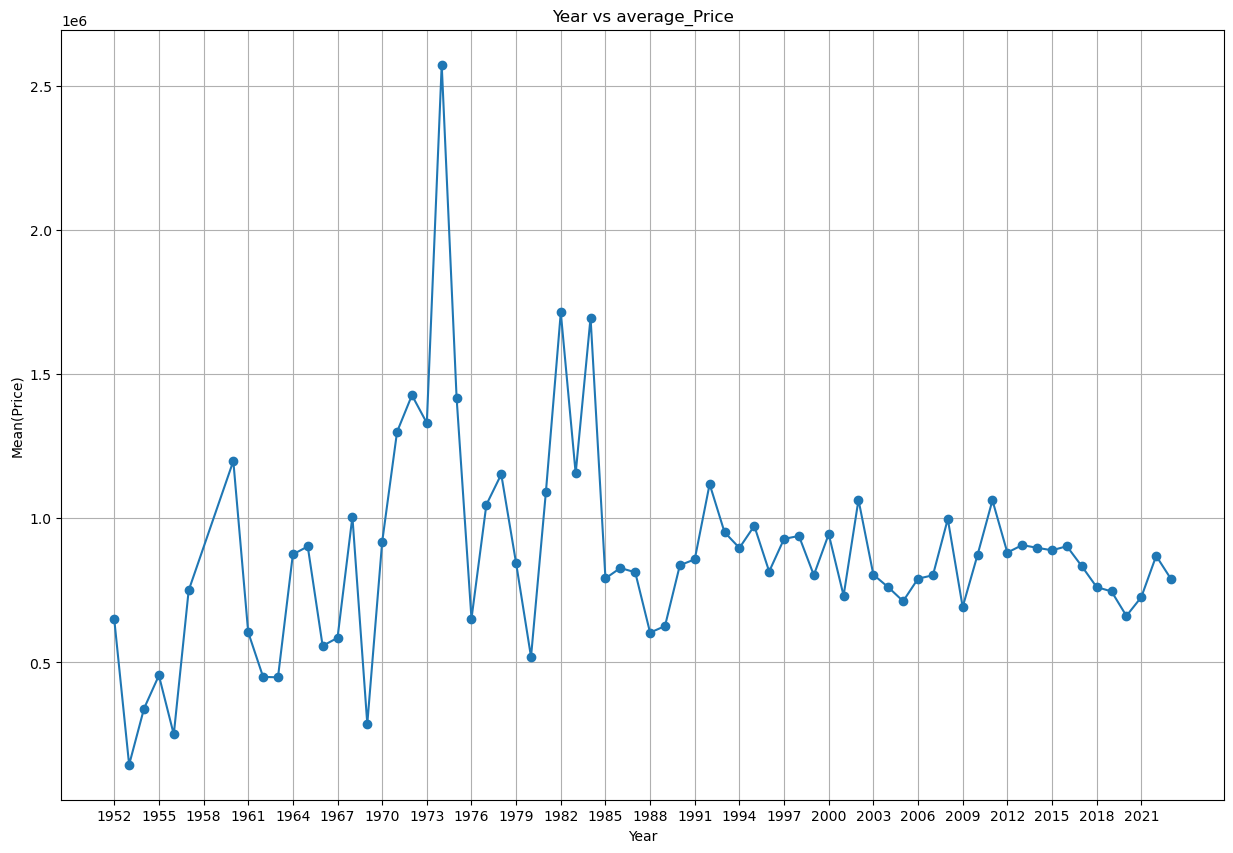

In [22]:
# import matplotlib.pyplot as plt

# plt.scatter(df['year'], df['price'])
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.title('Scatter plot of Year vs Price')
# plt.show()

# should only retain recods after 1985. Data prior to 1985 seems too thin and too volatile
df = df[df['year']>1950]
mean_prices = df.groupby('year')['price'].mean()

years = mean_prices.index.to_numpy()
mean_values = mean_prices.to_numpy()
plt.figure(figsize=(15, 10))
# Plotting
plt.plot(years, mean_values, marker='o')
plt.title('Year vs average_Price')
plt.xlabel('Year')
plt.ylabel('Mean(Price)')
plt.xticks(np.arange(min(years), max(years)+1, 3))
plt.grid(True)
plt.show()



In [23]:
# as per our project, we need past actual sales data to build a good predictio model. So we only filter the data based on the prev_sold_date.
#report = sv.analyze(dataset[dataset['prev_sold_date'].notna()], target_feat='price')
# due to many input variables are heavily left skewed, we need to cap them so we can see a better picture of what variables may have a trend with the price.
#report.show_notebook(layout='vertical') 

## Feature Eng

Bed / Acre_lot
<br> bath/ Acre_lot
<br> house_size/ Acre_lot
<br> A cateogrical variable for if Bath is greater than bed, if same, if bath is less than bed.
<br> Note1. use the filled_capped variable for these feature engineering
<br> Note2. the Acre_lot could be 0 for the records. We need evaluate if the 0 stands for missing records. Or the 0 stands for non-lowrise home, like apartments, etc. So the Acre_lot are just 0 for them. I would check the kaggle documentation.

In [24]:
# Bed / house size 
# Bath / house size 
dataset['bed/house_size_filled_capped'] = dataset['bed_filled_capped'] / dataset['house_size_filled_capped']
dataset['bath/house_size_filled_capped'] = dataset['bath_filled_capped'] / dataset['house_size_filled_capped']

# year of sold date. And only retain records after 1985 due to earlier data thin & volatile.
# month of sold date.
dataset['year'] = [int(x[:4]) for x in dataset.prev_sold_date]
dataset['month'] = [int(x[5:7]) for x in dataset['prev_sold_date']]
dataset = dataset[dataset['year']>=1985]

# bed vs bath
dataset['bed_vs_bath'] = np.where(dataset['bed_filled_capped'] < dataset['bath_filled_capped'], 'bed_less_than_bath', np.where(dataset['bed_filled_capped'] == dataset['bath_filled_capped'], 'bed_equal_bath', 'bed_more_than_bath'))

#Bed / Acre_lot
#bath/ Acre_lot
dataset['bed/acre_lot_filled_capped'] = dataset['bed_filled_capped'] / dataset['acre_lot_filled_capped']
dataset['bath/acre_lot_filled_capped'] = dataset['bath_filled_capped'] / dataset['acre_lot_filled_capped']
dataset['house_size/acre_lot_filled_capped'] = dataset['house_size_filled_capped'] / dataset['acre_lot_filled_capped']

In [25]:
dataset.describe(percentiles=[0.001,0.01,0.05,0.1,0.5, 0.95,0.99,0.999],include = 'all')

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,bed_missing,bath_missing,acre_lot_missing,house_size_missing,acre_lot_filled,house_size_filled,bed_filled,bath_filled,house_size_filled_capped,bed_filled_capped,bath_filled_capped,acre_lot_filled_capped,bed/house_size_filled_capped,bath/house_size_filled_capped,year,month,bed_vs_bath,bed/acre_lot_filled_capped,bath/acre_lot_filled_capped,house_size/acre_lot_filled_capped
count,439595,414405.000000,423565.000000,317585.000000,439595,439595,439595.000000,307916.000000,439595,4.395950e+05,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595.000000,439595,439595.000000,439595.000000,439595.000000
unique,1,NaN,NaN,NaN,1925,13,NaN,NaN,9196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
top,for_sale,NaN,NaN,NaN,New York,New Jersey,NaN,NaN,2018-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bed_more_than_bath,NaN,NaN,NaN
freq,439595,NaN,NaN,NaN,25475,149145,NaN,NaN,317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263461,NaN,NaN,NaN
mean,NaN,3.268964,2.422747,8.511642,NaN,NaN,7365.693118,2042.552660,NaN,8.291200e+05,0.057303,0.036465,0.277551,0.299546,9.171710,2044.699069,3.253552,2.407332,1983.736286,3.231590,2.387120,3.694946,0.001798,0.001288,2009.167845,6.739108,NaN,22.067906,15.172313,11881.834550
std,NaN,1.608411,1.378221,467.154315,NaN,NaN,3655.899552,2072.831858,NaN,2.730351e+06,0.232420,0.187445,0.447791,0.458060,397.068428,1734.819908,1.562899,1.355178,1043.921142,1.446534,1.238142,4.936436,0.000784,0.000508,9.276835,3.330812,NaN,36.878605,27.270735,20478.562804
min,NaN,1.000000,1.000000,0.000000,NaN,NaN,725.000000,104.000000,NaN,2.080000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,104.000000,1.000000,1.000000,500.000000,1.000000,1.000000,0.010000,0.000143,0.000143,1985.000000,1.000000,NaN,0.058824,0.058824,29.411765
0.1%,NaN,1.000000,1.000000,0.000000,NaN,NaN,1002.000000,350.000000,NaN,2.995000e+04,0.000000,0.000000,0.000000,0.000000,0.010000,375.000000,1.000000,1.000000,500.000000,1.000000,1.000000,0.010000,0.000429,0.000286,1985.000000,1.000000,NaN,0.091829,0.091829,45.914410
1%,NaN,1.000000,1.000000,0.010000,NaN,NaN,1075.000000,500.000000,NaN,7.500000e+04,0.000000,0.000000,0.000000,0.000000,0.020000,525.000000,1.000000,1.000000,525.000000,1.000000,1.000000,0.020000,0.000488,0.000488,1987.000000,1.000000,NaN,0.091829,0.091829,50.505851
5%,NaN,1.000000,1.000000,0.030000,NaN,NaN,1772.000000,681.000000,NaN,1.550000e+05,0.000000,0.000000,0.000000,0.000000,0.040000,744.000000,1.000000,1.000000,744.000000,1.000000,1.000000,0.040000,0.000789,0.000488,1991.000000,1.000000,NaN,0.091829,0.091829,73.463056


In [26]:
print(dataset.isna().sum())

status                                    0
bed                                   25190
bath                                  16030
acre_lot                             122010
city                                      0
state                                     0
zip_code                                  0
house_size                           131679
prev_sold_date                            0
price                                     0
bed_missing                               0
bath_missing                              0
acre_lot_missing                          0
house_size_missing                        0
acre_lot_filled                           0
house_size_filled                         0
bed_filled                                0
bath_filled                               0
house_size_filled_capped                  0
bed_filled_capped                         0
bath_filled_capped                        0
acre_lot_filled_capped                    0
bed/house_size_filled_capped    

In [27]:
# Export back the dataset to csv format. dataset as of Nov-11th. 
# remove columns that are not needed for modeling
# Removed the code. Don't want to overwrite it each time we run this notebook.
states_to_delete = ['Delaware','Georgia','Puerto Rico','Virgin Islands']
dataset = dataset[~dataset['state'].isin(states_to_delete)]

columns_to_drop = ['status', 'city', 'zip_code','prev_sold_date']
dataset = dataset.drop(columns=columns_to_drop)
# dataset.to_csv('../Data/cleaned_up_data.csv')
# dataset.to_parquet('../Data/cleaned_up_data.parquet')
# dataset.to_parquet('../Data/listing_price_only_data.parquet') 

## Preliminary EDA analysis. Plot input/response

In [28]:
data_eda = dataset.copy()

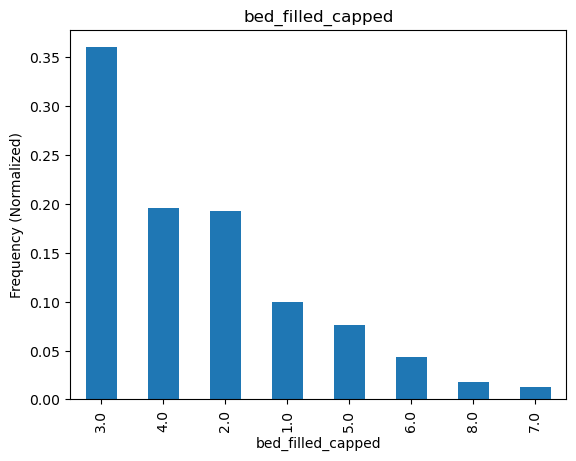

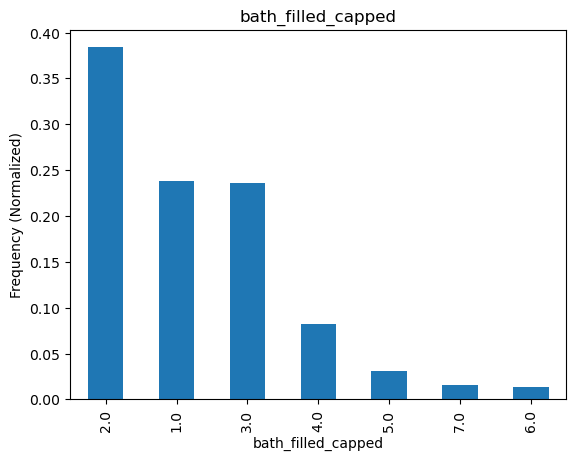

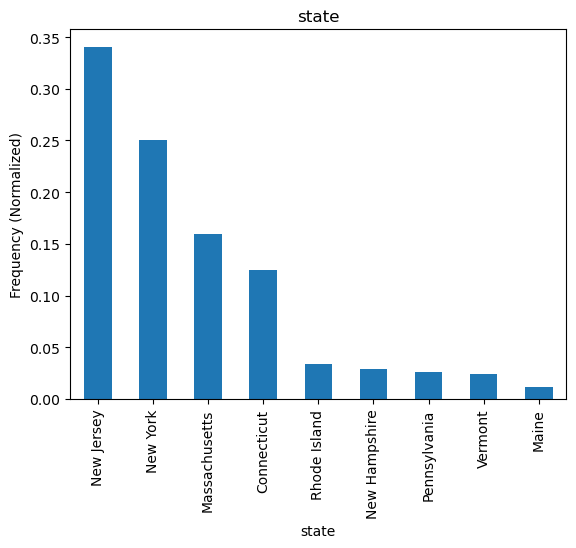

In [29]:
data_eda['bed_filled_capped'].value_counts(normalize=True).plot.bar(title='bed_filled_capped')
plt.ylabel('Frequency (Normalized)')
plt.show()
data_eda['bath_filled_capped'].value_counts(normalize=True).plot.bar(title='bath_filled_capped')
plt.ylabel('Frequency (Normalized)')
plt.show()
data_eda['state'].value_counts(normalize=True).plot.bar(title='state')
plt.ylabel('Frequency (Normalized)')
plt.show()


quantile_acre_lot
8    124946
1     53456
2     45405
5     44119
6     44055
4     43486
7     42762
3     33424
9      6496
Name: count, dtype: int64
quantile_acre_lot
1    8.423568e+05
2    6.236334e+05
3    5.589485e+05
4    5.519399e+05
5    6.161036e+05
6    7.734497e+05
7    8.882744e+05
8    1.101728e+06
9    1.701768e+06
Name: price, dtype: float64


Text(0, 0.5, 'price')

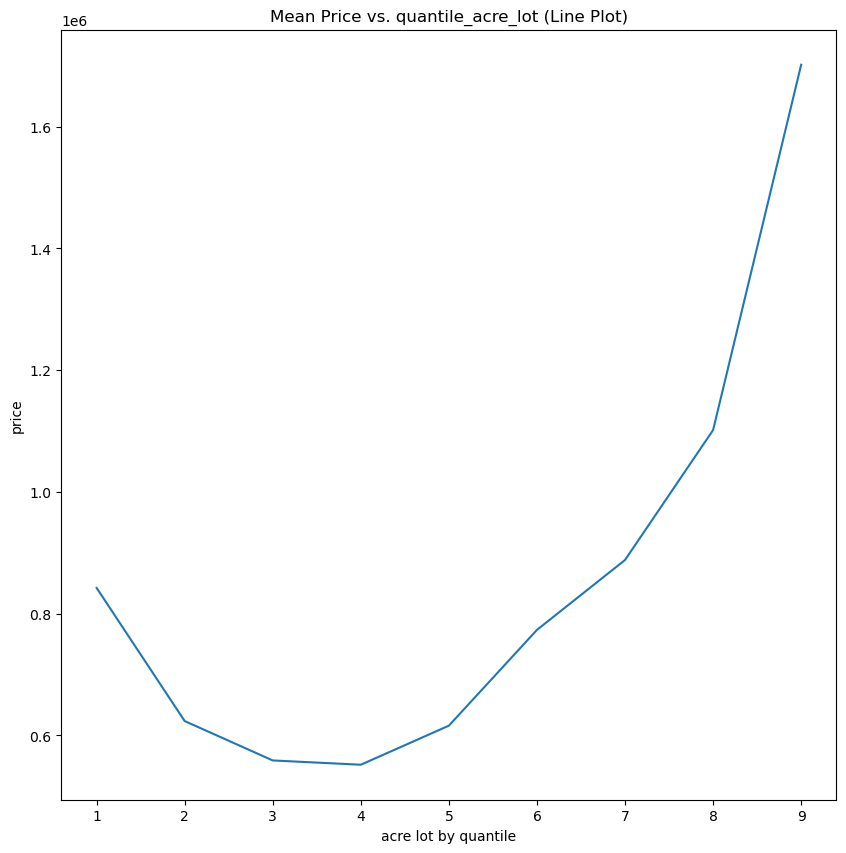

In [30]:
labels = range(1, 10) 
data_eda['quantile_acre_lot'] = pd.qcut(data_eda['acre_lot_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
print(data_eda['quantile_acre_lot'].value_counts())
quantile_grouped = data_eda.groupby(data_eda.quantile_acre_lot)['price'].mean()
print(quantile_grouped)
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_acre_lot', y='price')
plt.title('Mean Price vs. quantile_acre_lot (Line Plot)')
plt.xlabel('acre lot by quantile')
plt.ylabel('price')

In [31]:
# labels = range(0, 10) 
# data_eda['quantile_bed/acre_lot_filled_capped'] = pd.qcut(data_eda['bed/acre_lot_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
# print(data_eda['quantile_bed/acre_lot_filled_capped'].value_counts())
# quantile_grouped = data_eda.groupby(data_eda['quantile_bed/acre_lot_filled_capped'].astype(str))['price'].mean()
# plt.figure(figsize=(10, 10))
# quantile_grouped.plot(x='quantile_bed/acre_lot_filled_capped', y='price')
# plt.title('Mean Price vs. quantile_bed/acre_lot_filled_capped (Line Plot)')
# plt.xlabel('bed/acre_lot by quantile')
# plt.ylabel('price')

quantile_bath/acre_lot_filled_capped
0    57836
4    44982
7    44824
1    44759
5    43910
8    43697
3    42954
9    42656
6    42475
2    30056
Name: count, dtype: int64


Text(0, 0.5, 'price')

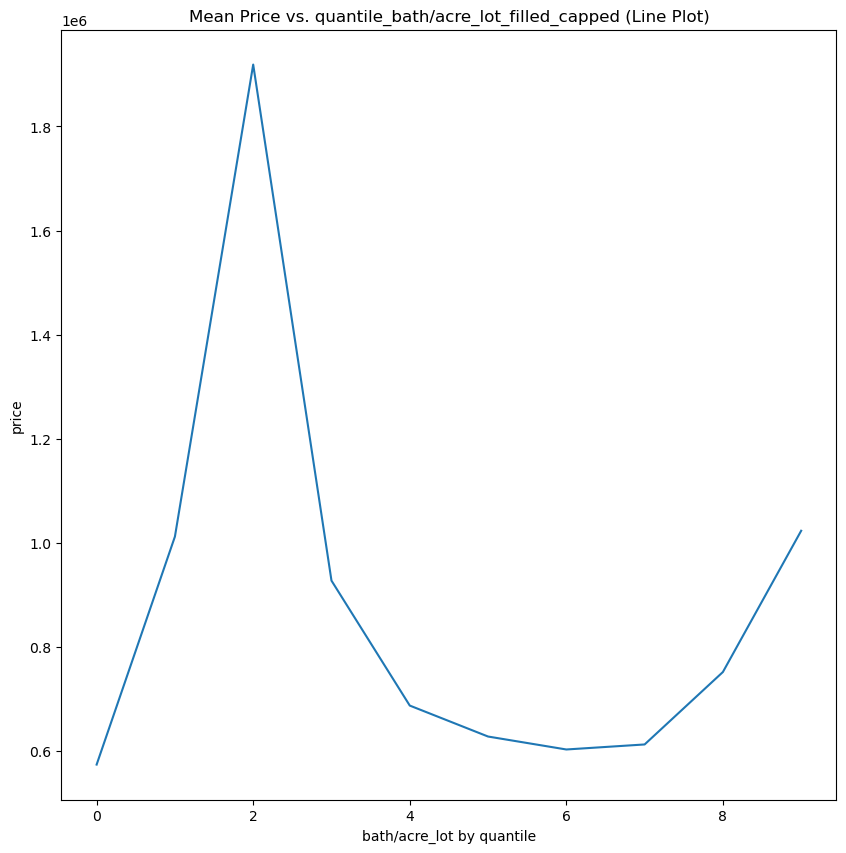

In [32]:
labels = range(0, 10) 
data_eda['quantile_bath/acre_lot_filled_capped'] = pd.qcut(data_eda['bath/acre_lot_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
print(data_eda['quantile_bath/acre_lot_filled_capped'].value_counts())
quantile_grouped = data_eda.groupby(data_eda['quantile_bath/acre_lot_filled_capped'].astype(str))['price'].mean()
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_bath/acre_lot_filled_capped', y='price')
plt.title('Mean Price vs. quantile_bath/acre_lot_filled_capped (Line Plot)')
plt.xlabel('bath/acre_lot by quantile')
plt.ylabel('price')

quantile_house_size/acre_lot_filled_capped
1    74220
8    46217
7    45945
4    44325
3    43929
0    43887
6    43826
5    43180
9    39272
2    13348
Name: count, dtype: int64


Text(0, 0.5, 'price')

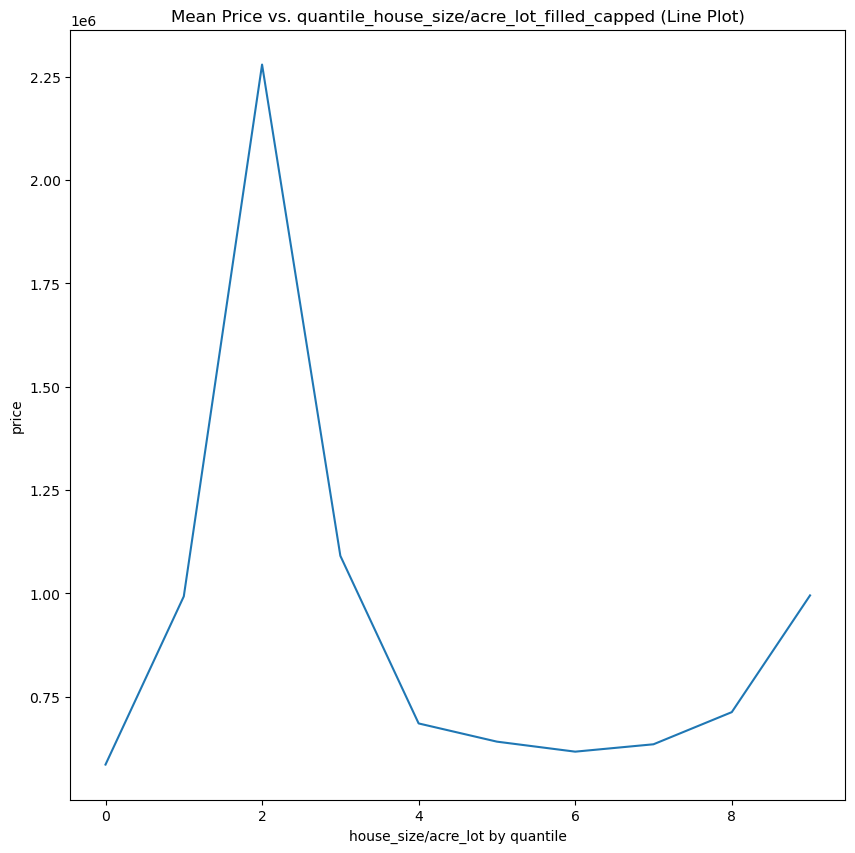

In [33]:
labels = range(0, 10) 
data_eda['quantile_house_size/acre_lot_filled_capped'] = pd.qcut(data_eda['house_size/acre_lot_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
print(data_eda['quantile_house_size/acre_lot_filled_capped'].value_counts())
quantile_grouped = data_eda.groupby(data_eda['quantile_house_size/acre_lot_filled_capped'].astype(str))['price'].mean()
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_house_size/acre_lot_filled_capped', y='price')
plt.title('Mean Price vs. quantile_house_size/acre_lot_filled_capped (Line Plot)')
plt.xlabel('house_size/acre_lot by quantile')
plt.ylabel('price')

quantile_house_size
4    159833
0     43953
2     43913
3     43844
7     43809
6     43772
1     43677
5     15348
Name: count, dtype: int64


Text(0, 0.5, 'price')

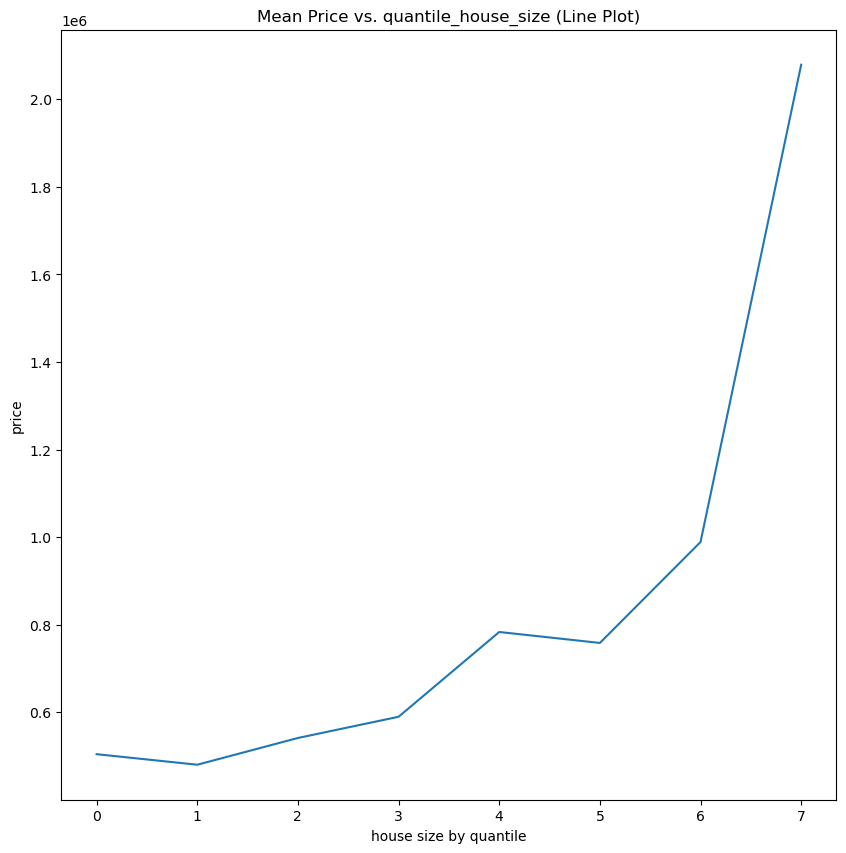

In [34]:
labels = range(0, 8) 
data_eda['quantile_house_size'] = pd.qcut(data_eda['house_size_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
print(data_eda['quantile_house_size'].value_counts())
quantile_grouped = data_eda.groupby(data_eda.quantile_house_size.astype(str))['price'].mean()
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_house_size', y='price')
plt.title('Mean Price vs. quantile_house_size (Line Plot)')
plt.xlabel('house size by quantile')
plt.ylabel('price')

quantile_house_size
4    159833
0     43953
2     43913
3     43844
7     43809
6     43772
1     43677
5     15348
Name: count, dtype: int64


Text(0, 0.5, 'price')

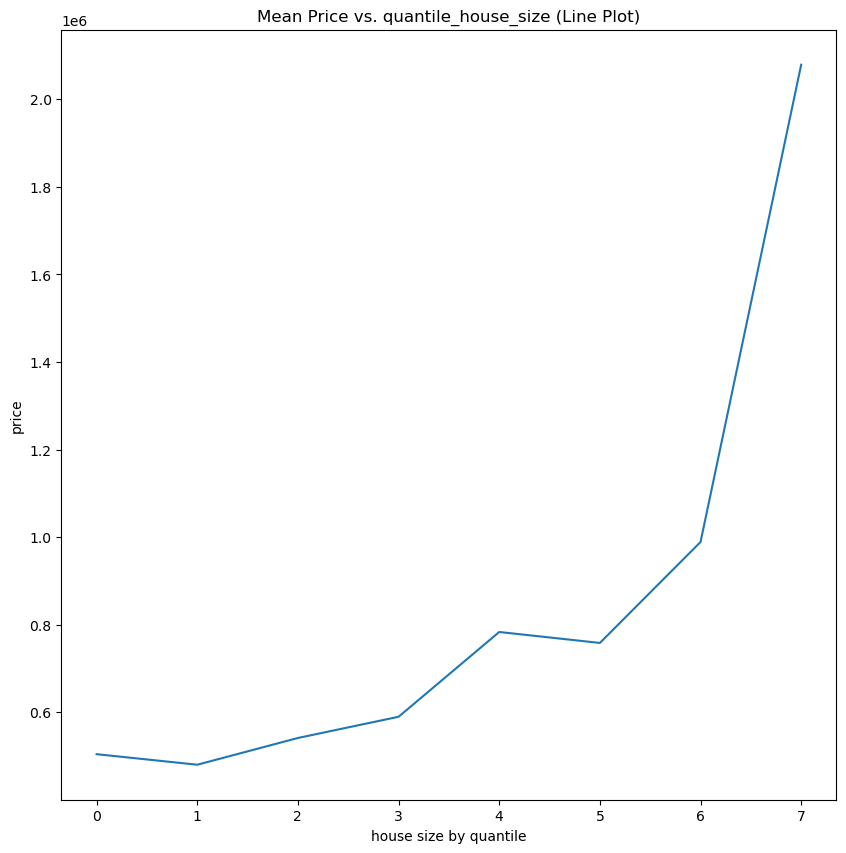

In [35]:
labels = range(0, 8) 
data_eda['quantile_house_size'] = pd.qcut(data_eda['house_size_filled_capped'], q=10, labels=labels, precision=0, duplicates='drop')
print(data_eda['quantile_house_size'].value_counts())
quantile_grouped = data_eda.groupby(data_eda.quantile_house_size)['price'].mean()
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_house_size', y='price')
plt.title('Mean Price vs. quantile_house_size (Line Plot)')
plt.xlabel('house size by quantile')
plt.ylabel('price')

quantile_house_size2
3    31894
1    31090
0    30705
8    30664
9    30644
7    30576
6    30557
5    30270
2    30176
4    29987
Name: count, dtype: int64


Text(0, 0.5, 'price')

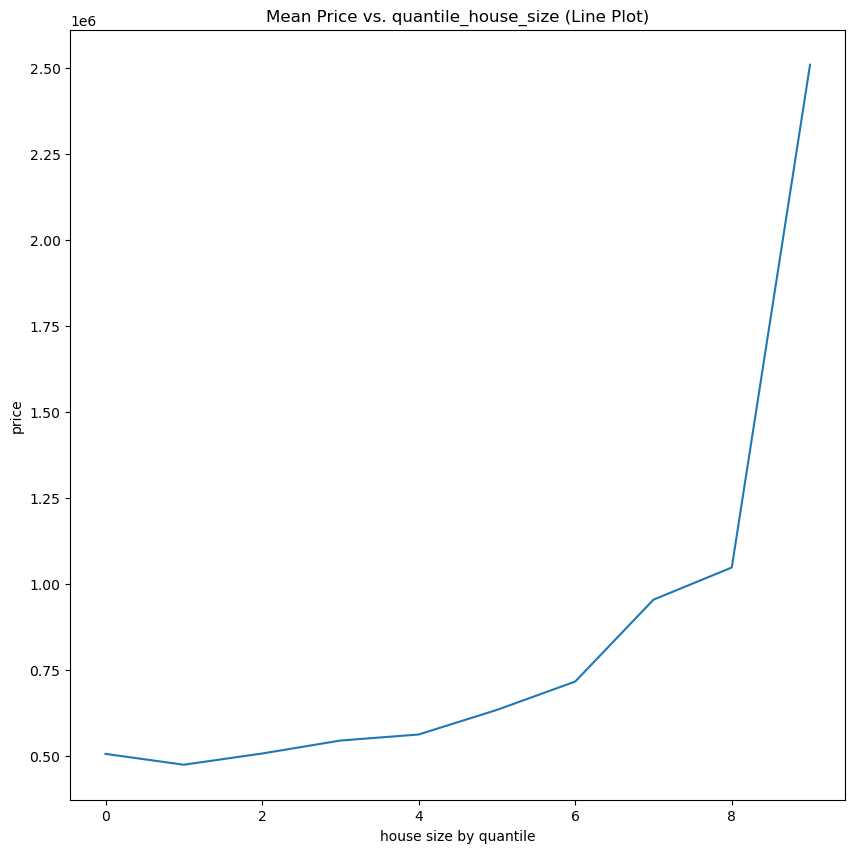

In [36]:
# see the graph before fillna & cap/floor
# Note after fillna with mean, we will have a high concentration on decile 4 (mean)
# the price for that decile 4 is even higher than decile 5. due to the avg_price for 'Nan' is higher than decile 5.
labels = range(0, 10) 
data_eda['quantile_house_size2'] = pd.qcut(data_eda['house_size'], q=10, labels=labels, precision=0)
print(data_eda['quantile_house_size2'].value_counts())
quantile_grouped = data_eda.groupby(data_eda.quantile_house_size2)['price'].mean()
plt.figure(figsize=(10, 10))
quantile_grouped.plot(x='quantile_house_size2', y='price')
plt.title('Mean Price vs. quantile_house_size (Line Plot)')
plt.xlabel('house size by quantile')
plt.ylabel('price')

After fillna with the mean of house size, which is around decile 4 in the first graph, we are bring up the decile 4's average price.
<br>So that's why are are seeing a reversal of the average price across the deciles in the first graph.

In [37]:
# plt.figure(figsize=(8,5))
# sns.boxplot(x='state',y='price',data=data_eda, palette='rainbow')
# plt.title("state & price")
# plt.show()

Text(0, 0.5, 'price')

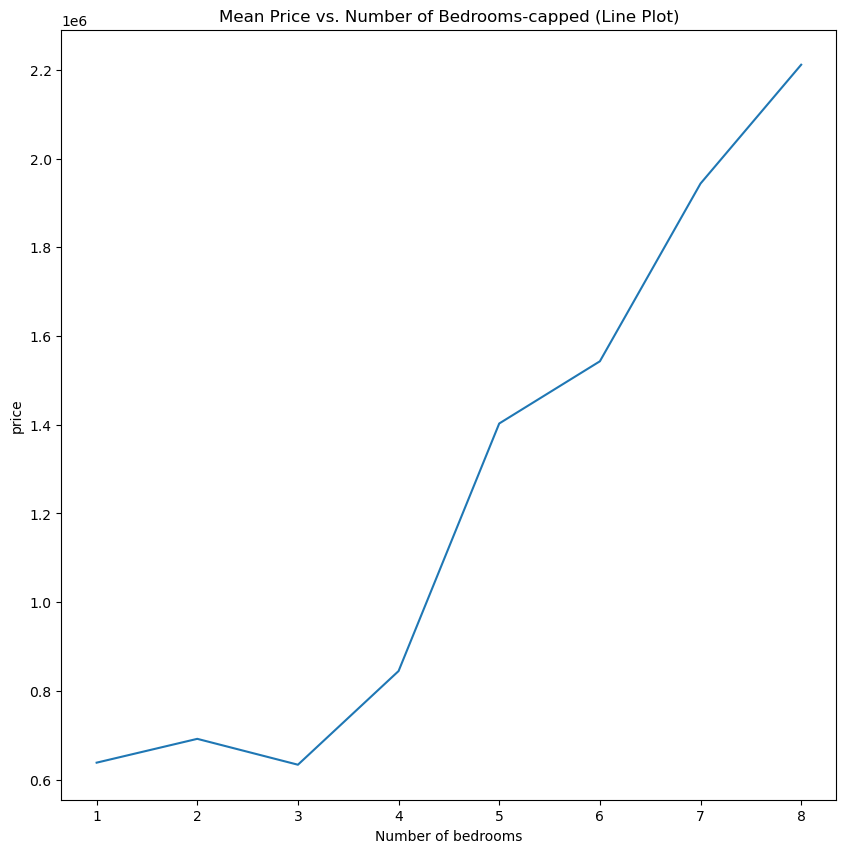

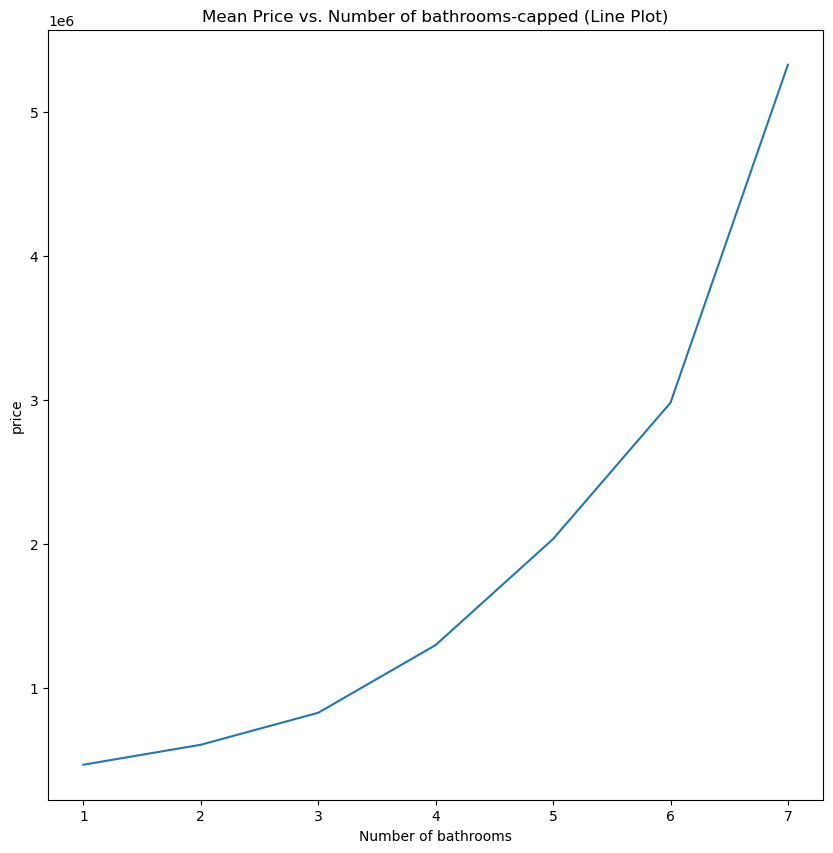

In [38]:
#bed_mean_prices = data_eda.groupby('bed2')['price'].mean()
plt.figure(figsize=(10, 10))
plt.plot(data_eda.groupby('bed_filled_capped')['price'].mean())
plt.title('Mean Price vs. Number of Bedrooms-capped (Line Plot)')
plt.xlabel('Number of bedrooms')
plt.ylabel('price')

plt.figure(figsize=(10, 10))
plt.plot(data_eda.groupby('bath_filled_capped')['price'].mean())
plt.title('Mean Price vs. Number of bathrooms-capped (Line Plot)')
plt.xlabel('Number of bathrooms')
plt.ylabel('price')

# plt.figure(figsize=(10, 10))
# plt.plot(data_eda.groupby('state')['price'].mean())
# plt.title('Mean Price vs state (Line Plot)')
# plt.xlabel('state')
# plt.ylabel('price')

In [39]:
print(data_eda.loc[data_eda['bed'].isna()]['price'].mean())
data_eda.groupby('bed_filled_capped')['price'].mean()

541078.315804129


bed_filled_capped
1.0    6.380418e+05
2.0    6.917355e+05
3.0    6.333994e+05
4.0    8.446003e+05
5.0    1.402669e+06
6.0    1.542889e+06
7.0    1.943600e+06
8.0    2.211483e+06
Name: price, dtype: float64

The average price for the 'bed' empty level is at 5.33e+5.
<br>This is why after fillna with median (3) for bed, the level '3's average price has decreased. 

<Axes: >

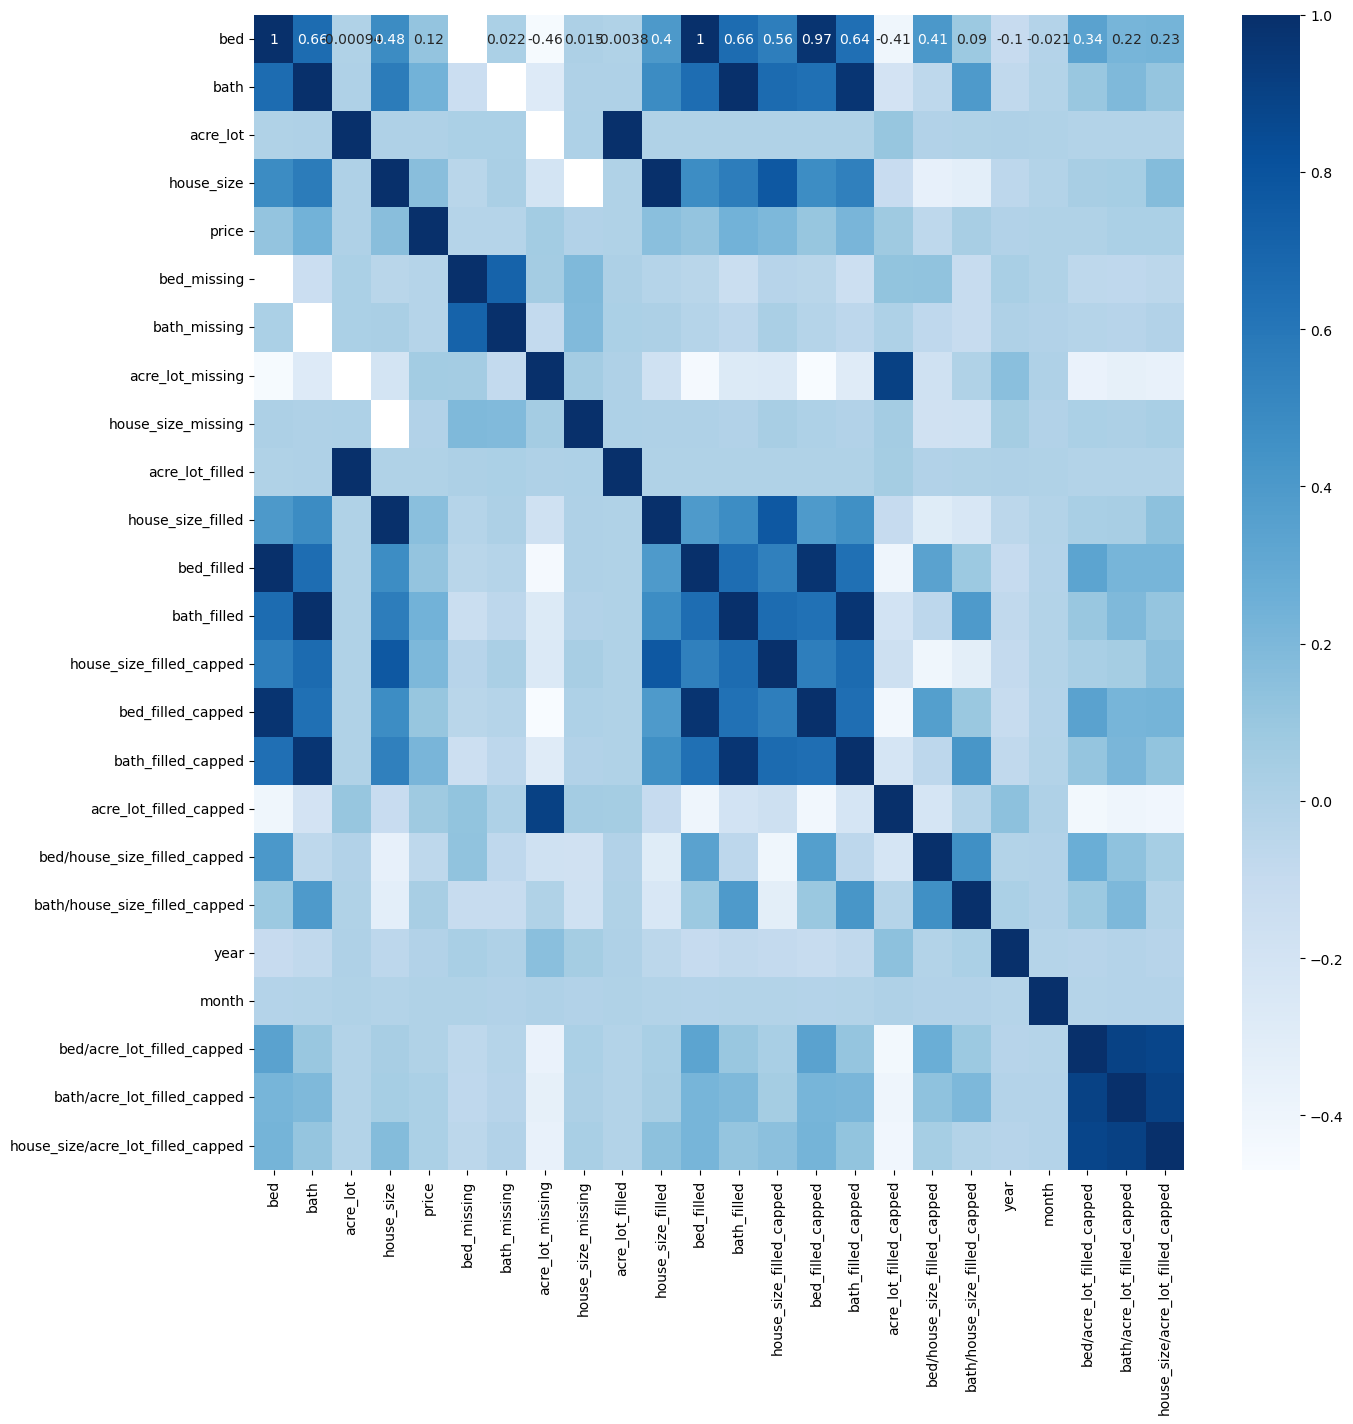

In [40]:
plt.figure(figsize=(15,15))
numeric_columns = data_eda.select_dtypes(include=['number'])
sns.heatmap(numeric_columns.corr(), cbar=True, annot=True, cmap='Blues')

## Modelling Stage

In [41]:
# only retain variables intestested
variables = ['price',
            'state',
            'bed_vs_bath',
            'house_size_filled_capped',
            'bed_filled_capped',
            'bath_filled_capped',
            'acre_lot_filled_capped',
            'bed/house_size_filled_capped',
            'bath/house_size_filled_capped',
            'year',
            'month',
            'bed/acre_lot_filled_capped',
            'bath/acre_lot_filled_capped',
            'house_size/acre_lot_filled_capped']
dataset = dataset.loc[:,variables]

dataset.head()


,price,state,bed_vs_bath,house_size_filled_capped,bed_filled_capped,bath_filled_capped,acre_lot_filled_capped,bed/house_size_filled_capped,bath/house_size_filled_capped,year,month,bed/acre_lot_filled_capped,bath/acre_lot_filled_capped,house_size/acre_lot_filled_capped
24233,169900.0,Massachusetts,bed_equal_bath,892.0,2.0,2.0,10.889827,0.002242,0.002242,2019,4,0.183658,0.183658,81.911307
24237,525000.0,Massachusetts,bed_equal_bath,2314.0,3.0,3.0,0.450000,0.001296,0.001296,2014,6,6.666667,6.666667,5142.222222
24238,289900.0,Massachusetts,bed_more_than_bath,1276.0,3.0,2.0,0.360000,0.002351,0.001567,2012,10,8.333333,5.555556,3544.444444
24239,239900.0,Massachusetts,bed_less_than_bath,1229.0,2.0,3.0,10.889827,0.001627,0.002441,2016,6,0.183658,0.275486,112.857619
24240,249900.0,Massachusetts,bed_more_than_bath,860.0,2.0,1.0,10.889827,0.002326,0.001163,1997,1,0.183658,0.091829,78.972785


In [42]:
# random split into 60/20/20 for training/validation/test. using fixed random_state
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.4, random_state=999)
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=999)
print(len(train_data))
print(len(validation_data))
print(len(test_data))

262889
87630
87630


In [43]:
train_data.head()

,price,state,bed_vs_bath,house_size_filled_capped,bed_filled_capped,bath_filled_capped,acre_lot_filled_capped,bed/house_size_filled_capped,bath/house_size_filled_capped,year,month,bed/acre_lot_filled_capped,bath/acre_lot_filled_capped,house_size/acre_lot_filled_capped
587682,395000.0,New Jersey,bed_less_than_bath,2049.718197,2.0,3.0,10.889827,0.000976,0.001464,2017,12,0.183658,0.275486,188.223203
453677,325000.0,Connecticut,bed_less_than_bath,1992.000000,2.0,3.0,10.889827,0.001004,0.001506,2015,9,0.183658,0.275486,182.923009
719474,1450000.0,New York,bed_equal_bath,1186.000000,2.0,2.0,10.889827,0.001686,0.001686,2014,10,0.183658,0.183658,108.908980
240276,275000.0,Connecticut,bed_equal_bath,1442.000000,2.0,2.0,0.370000,0.001387,0.001387,2021,5,5.405405,5.405405,3897.297297
101459,425000.0,Rhode Island,bed_more_than_bath,6798.000000,8.0,4.0,0.110000,0.001177,0.000588,2008,1,72.727273,36.363636,61800.000000


In [44]:
# export to csv for ease of use in later R codes. Nov-11th. Removed the code. Don't want to overwrite it each time we run this notebook.
# train_data.to_csv('../Data/training_data.csv')
# validation_data.to_csv('../Data/validation_data.csv')
# test_data.to_csv('../Data/test_data.csv')

# train_data.to_parquet('../Data/training_data.parquet')
# validation_data.to_parquet('../Data/validation_data.parquet')
# test_data.to_parquet('../Data/test_data.parquet')

In [5]:
# Setup a function to do model evaluation and print results
def score_model(model,X_train,y_train,X_valid,y_valid):
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    print(f"-"*83)
    print(f"RESULTS")
    print(f"Train MSE:{mean_squared_error(y_train,train_pred,squared=True):.3f}, Valid MSE:{mean_squared_error(y_valid,valid_pred,squared=True):.3f}")
    print(f"Train RMSE:{mean_squared_error(y_train,train_pred,squared=False):.3f}, Valid RMSE:{mean_squared_error(y_valid,valid_pred,squared=False):.3f}")
    print(f"Train R2:{r2_score(y_train,train_pred):.3f}, Valid R2:{r2_score(y_valid,valid_pred):.3f}")
    # print(f"Train MSLE:{mean_squared_log_error(y_train,train_pred):.3f}, Valid MSLE:{mean_squared_log_error(y_valid,valid_pred):.3f}")
    print(f"Train MAE:{mean_absolute_error(y_train,train_pred):.3f}, Valid MAE:{mean_absolute_error(y_valid,valid_pred):.3f}")
    print(f"Train MAPE:{mean_absolute_percentage_error(y_train,train_pred):.3f}, Valid MAPE:{mean_absolute_percentage_error(y_valid,valid_pred):.3f}")
    return


In [6]:
# Setup a function to do one-hot encode the cateogorical variables
def one_hot(input):
    output_df = input.copy()
    bed_bath_var = ['bed_equal_bath', 'bed_more_than_bath', 'bed_less_than_bath']
    for var in bed_bath_var:
        output_df[var] = np.where(output_df['bed_vs_bath'] == var, 1, 0)
    states = ['New York', 'Massachusetts', 'New Jersey', 'Connecticut', 'Pennsylvania', 'Vermont', 
              'New Hampshire', 'Rhode Island', 'Maine']
    for state in states:
        output_df[state] = np.where(output_df['state'] == state, 1, 0)
    for state in set(states) - set(output_df['state'].unique()):
        output_df[state] = 0

    month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    output_df['month'] = output_df['month'].apply(lambda x: month_dict[x])
    month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for month in month_list:
        output_df[month] = np.where(output_df['month'] == month, 1, 0)
    for month in set(month_list) - set(output_df['month'].unique()):
        output_df[month] = 0

    output_df = output_df.drop(['bed_vs_bath', 'state','month'], axis=1)
    
    return output_df

In [7]:
# def actual_vs_predicted(input,actual_col,pred_col):
#     df = input.copy()
#     df = df.sort_values(actual_col)
#     df['bin'] = pd.qcut(df[actual_col], q=10)
#     grouped = df.groupby('bin').agg({actual_col: np.mean, pred_col: np.mean})
#     grouped.reset_index(inplace=True)

#     plt.figure(figsize=(10, 6))
#     plt.plot(grouped[actual_col], label='Actual')
#     plt.plot(grouped[pred_col], label='Predicted')
#     plt.legend()
#     plt.show()
#     result_df = grouped.copy()

#     return result_df

In [1]:
# create a function to plot the actual vs predicted on 10 equal deciles.
# Also creates a dataframe to visualize the model performance on each decile using % difference.
def actual_vs_predicted(input,actual_col,pred_col):
    df = input.copy()
    df = df.sort_values(actual_col)
    df['bin'] = pd.qcut(df[actual_col], q=10)
    grouped = df.groupby('bin').agg({actual_col: np.mean, pred_col: np.mean})
    grouped.reset_index(inplace=True)

    plt.figure(figsize=(10, 6))
    plt.plot(grouped[actual_col], label='Actual')
    plt.plot(grouped[pred_col], label='Predicted')
    plt.legend()
    plt.xlim(0,9)
    plt.show()

    grouped['% diff'] = (grouped[pred_col] / grouped[actual_col] - 1) * 100
    result_df = grouped.copy()

    return result_df

In [9]:
y_train = train_data['price']
# y_train = np.log(train_data['price'])
X_train = train_data.drop('price',axis=1)

y_valid = validation_data['price']
# y_valid = np.log(validation_data['price'])
X_valid = validation_data.drop('price',axis=1)

y_test = test_data['price']
# y_test = np.log(test_data['price'])
X_test = test_data.drop('price',axis=1)


In [10]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
num_features = list(X_train.select_dtypes(include=['float64','int64']).columns)
print(cat_features)
print(num_features)

['state', 'bed_vs_bath']
['house_size_filled_capped', 'bed_filled_capped', 'bath_filled_capped', 'acre_lot_filled_capped', 'bed/house_size_filled_capped', 'bath/house_size_filled_capped', 'year', 'month', 'bed/acre_lot_filled_capped', 'bath/acre_lot_filled_capped', 'house_size/acre_lot_filled_capped']


In [51]:
# create a baseline model - random forest regressor. using default parameters
# need to one-hot encode the cateogorical variables
start_time = time.time()
X_train_encoded = one_hot(X_train)
X_valid_encoded = one_hot(X_valid)

rf = RandomForestRegressor(random_state=123)
rf.fit(X_train_encoded,y_train)

score_model(rf,X_train_encoded,y_train,X_valid_encoded,y_valid)

end_time = time.time()
execution_time = end_time - start_time
print(f"The code executed in {execution_time} seconds.")

-----------------------------------------------------------------------------------
RESULTS
Train MSE:109802301476.731, Valid MSE:130921647814.126
Train RMSE:331364.303, Valid RMSE:361830.966
Train R2:0.986, Valid R2:0.945
Train MAE:26599.053, Valid MAE:45771.108
Train MAPE:0.041, Valid MAPE:0.070
The code executed in 202.92967009544373 seconds.


In [52]:
X_test_encoded = one_hot(X_test)
test_pred = rf.predict(X_test_encoded)
y_test = test_data['price']
mean_squared_error(y_test,test_pred,squared=False)

461641.65768129134

In [53]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

RF model. Training RMSE 331364, validation RMSE 361830, test RMSE 461641. RF seems underfitting.
<br> using default parameters. while setting random state to 123
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False

In [22]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

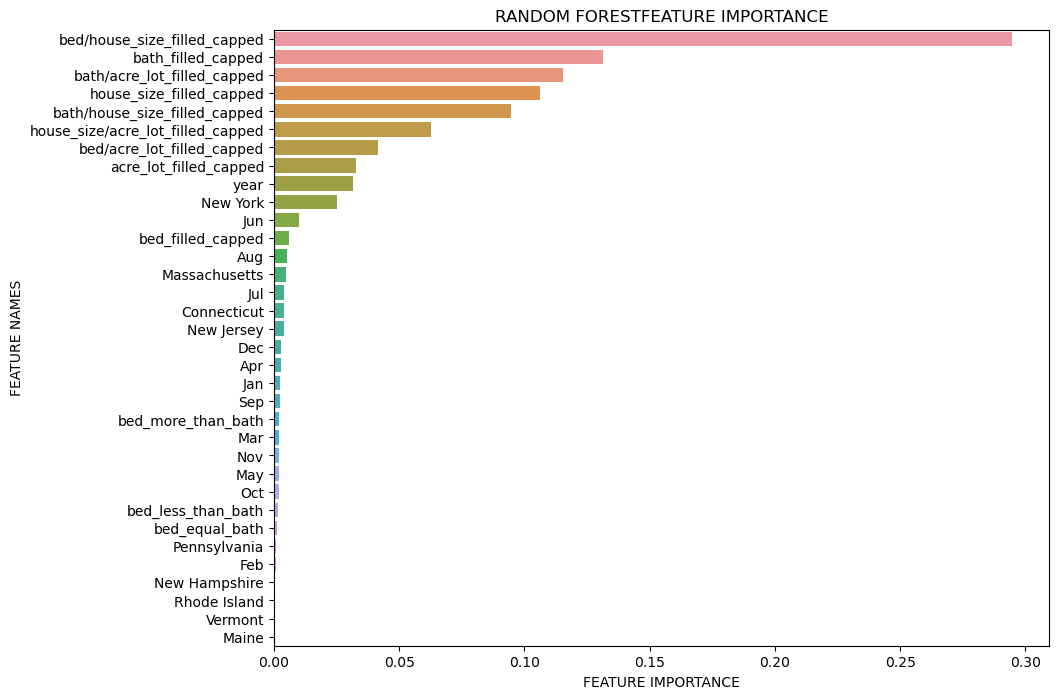

In [55]:
plot_feature_importance(rf.feature_importances_,X_train_encoded.columns,'RANDOM FOREST')

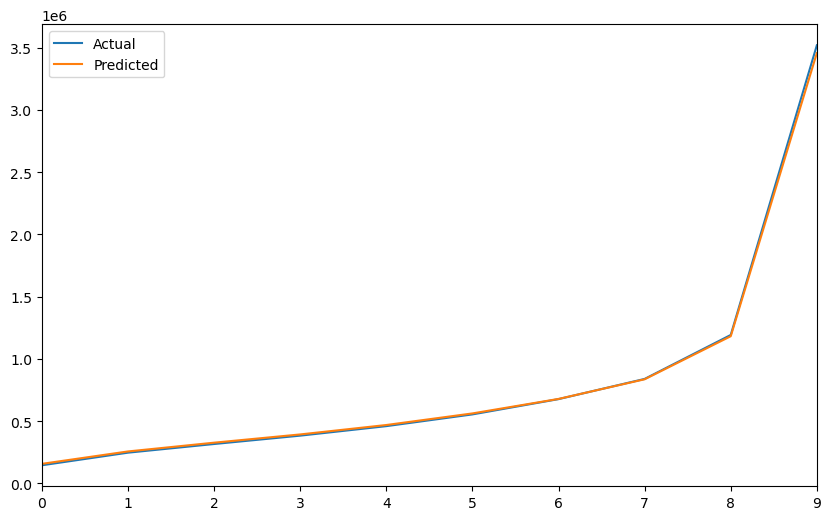

,bin,price,predicted_price,% diff
0,"(20999.999, 209000.0]",1.460939e+05,1.575828e+05,7.864033
1,"(209000.0, 280000.0]",2.473352e+05,2.571542e+05,3.969922
2,"(280000.0, 349900.0]",3.168517e+05,3.275277e+05,3.369406
3,"(349900.0, 419900.0]",3.840645e+05,3.938053e+05,2.536231
4,"(419900.0, 499000.0]",4.603653e+05,4.694856e+05,1.981097
5,"(499000.0, 600000.0]",5.546495e+05,5.625361e+05,1.421896
6,"(600000.0, 749000.0]",6.773620e+05,6.789212e+05,0.230184
7,"(749000.0, 949900.0]",8.396428e+05,8.366663e+05,-0.354492
8,"(949900.0, 1499900.0]",1.192671e+06,1.182423e+06,-0.859293
9,"(1499900.0, 875000000.0]",3.519178e+06,3.456506e+06,-1.780874


In [56]:
# random forest model performance on training dataset
train_pred = rf.predict(X_train_encoded)
y_train_df = y_train.to_frame() 
y_train_df['predicted_price'] = train_pred.tolist()
actual_vs_predicted(y_train_df,'price','predicted_price')

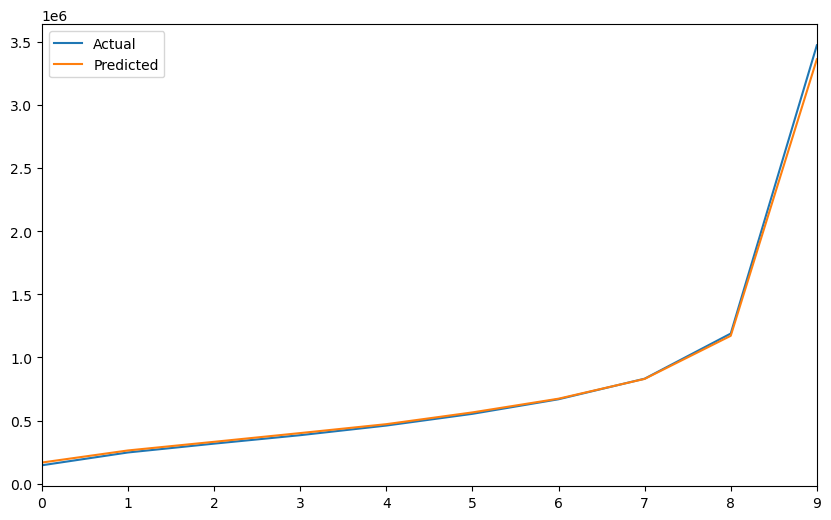

,bin,price,predicted_price,% diff
0,"(21899.999, 209000.0]",1.459123e+05,1.675648e+05,14.839408
1,"(209000.0, 280000.0]",2.473823e+05,2.633098e+05,6.438426
2,"(280000.0, 349900.0]",3.172891e+05,3.317388e+05,4.554100
3,"(349900.0, 419900.0]",3.841754e+05,4.008875e+05,4.350137
4,"(419900.0, 499000.0]",4.604341e+05,4.714851e+05,2.400128
5,"(499000.0, 599900.0]",5.532866e+05,5.645708e+05,2.039484
6,"(599900.0, 739000.0]",6.687597e+05,6.732590e+05,0.672783
7,"(739000.0, 949000.0]",8.315160e+05,8.298930e+05,-0.195196
8,"(949000.0, 1499000.0]",1.189142e+06,1.171227e+06,-1.506520
9,"(1499000.0, 80000000.0]",3.471964e+06,3.361364e+06,-3.185527


In [57]:
# random forest model performance on validation dataset
valid_pred = rf.predict(X_valid_encoded)
y_valid_df = y_valid.to_frame() 
y_valid_df['predicted_price'] = valid_pred.tolist()
actual_vs_predicted(y_valid_df,'price','predicted_price')

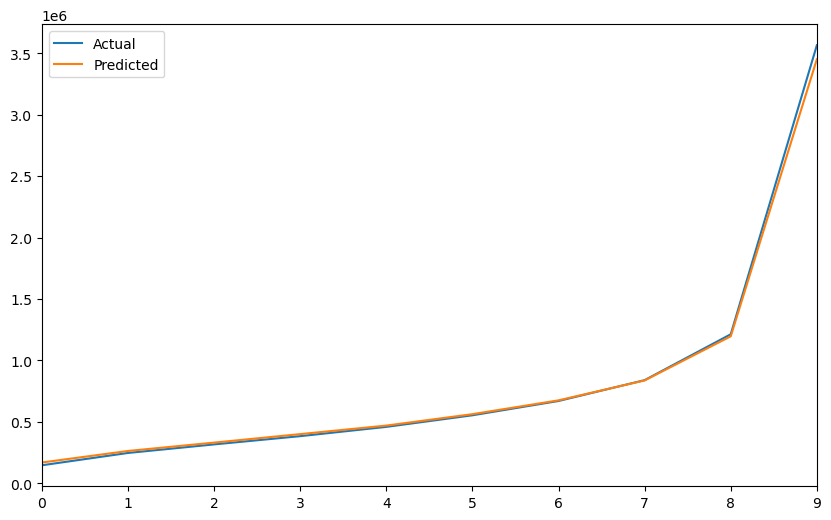

,bin,price,predicted_price,% diff
0,"(20799.999, 209500.0]",1.462774e+05,1.687961e+05,15.394545
1,"(209500.0, 279900.0]",2.465207e+05,2.626597e+05,6.546713
2,"(279900.0, 349900.0]",3.161726e+05,3.306851e+05,4.590058
3,"(349900.0, 419000.0]",3.832265e+05,3.999082e+05,4.352947
4,"(419000.0, 499000.0]",4.587775e+05,4.693331e+05,2.300811
5,"(499000.0, 599900.0]",5.530814e+05,5.621984e+05,1.648393
6,"(599900.0, 744900.0]",6.694738e+05,6.746820e+05,0.777946
7,"(744900.0, 950000.0]",8.390530e+05,8.367204e+05,-0.278011
8,"(950000.0, 1500000.0]",1.212641e+06,1.195899e+06,-1.380658
9,"(1500000.0, 875000000.0]",3.564450e+06,3.450772e+06,-3.189193


In [58]:
# random forest model performance on test dataset
test_data['predicted_price'] = test_pred.tolist()
actual_vs_predicted(test_data,'price','predicted_price')

In [2]:
##load
# train_data = pd.read_parquet(r'C:\Users\yexin\OneDrive\Documents\GitHub\Team-4\Data\training_data.parquet')
# validation_data = pd.read_parquet(r'C:\Users\yexin\OneDrive\Documents\GitHub\Team-4\Data\validation_data.parquet')
# test_data = pd.read_parquet(r'C:\Users\yexin\OneDrive\Documents\GitHub\Team-4\Data\test_data.parquet')

In [16]:
# SVR. using default parameters
from sklearn.svm import SVR
from sklearnex import patch_sklearn
from sklearn.preprocessing import StandardScaler
patch_sklearn()

#X_train_encoded=X_train_encoded.fillna(-1)
#X_valid_encoded=X_valid_encoded.fillna(-1)

X_train_encoded = one_hot(X_train)
X_valid_encoded = one_hot(X_valid)
X_test_encoded = one_hot(X_test)

# Create a StandardScaler instance and fit to the training data
scaler = StandardScaler()
scaler.fit(X_train_encoded)

# Scale the training and testing data
X_train_scaled = scaler.transform(X_train_encoded)
X_valid_scaled = scaler.transform(X_valid_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


##parameter search 
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error, r2_score

# Define a range of hyperparameters for the SVR
#param_grid = {
#    'C': [0.1, 1, 10, 100],             # Regularization parameter
#    'epsilon': [0.01, 0.1, 0.2, 0.5],   # Epsilon parameter in the epsilon-SVR model
#    'kernel': ['linear', 'rbf'],        # Kernel types to be tested
#    'gamma': ['scale', 'auto']          # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#}

# Initialize the SVR model
#svr = SVR()

# Initialize GridSearchCV with cross-validation
#grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model on training data
#grid_search.fit(X_train, y_train)

# Get the best estimator
#best_svr = grid_search.best_estimator_

## the best paramter is kernel='linear', C=1.0, epsilon=0.01, gamma= 'scale'

start_time = time.time()
svr = SVR(kernel='linear', C=1.0, epsilon=0.01, gamma= 'scale',max_iter=1000)
svr.fit(X_train_encoded, y_train)

train_pred = svr.predict(X_train_scaled)
valid_pred = svr.predict(X_valid_encoded)
test_pred = svr.predict(X_test_encoded)
print(f"-"*83)
print(f"RESULTS")
print(f"Train MSE:{mean_squared_error(y_train,train_pred,squared=True):.3f}, Valid MSE:{mean_squared_error(y_valid,valid_pred,squared=True):.3f}")
print(f"Train RMSE:{mean_squared_error(y_train,train_pred,squared=False):.3f}, Valid RMSE:{mean_squared_error(y_valid,valid_pred,squared=False):.3f}")
print(f"Train R2:{r2_score(y_train,train_pred):.3f}, Valid R2:{r2_score(y_valid,valid_pred):.3f}")
#print(f"Train MSLE:{mean_squared_log_error(y_train,train_pred):.3f}, Valid MSLE:{mean_squared_log_error(y_valid,valid_pred):.3f}")
print(f"Train MAE:{mean_absolute_error(y_train,train_pred):.3f}, Valid MAE:{mean_absolute_error(y_valid,valid_pred):.3f}")
print(f"Train MAPE:{mean_absolute_percentage_error(y_train,train_pred):.3f}, Valid MAPE:{mean_absolute_percentage_error(y_valid,valid_pred):.3f}")


end_time = time.time()
execution_time = end_time - start_time
print(f"The code executed in {execution_time} seconds.")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
C:\Users\yexin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


-----------------------------------------------------------------------------------
RESULTS
Train MSE:10739382662952.764, Valid MSE:2151247618499.601
Train RMSE:3277099.733, Valid RMSE:1466713.203
Train R2:-0.331, Valid R2:0.089


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

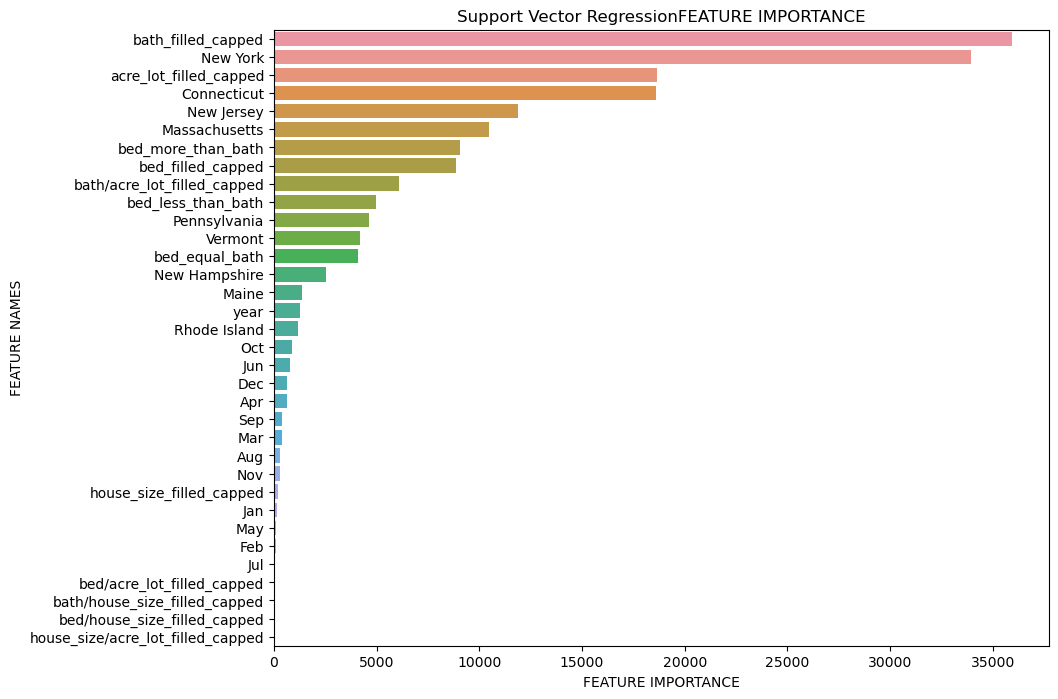

In [23]:
plot_feature_importance(np.abs(svr.coef_[0]),X_train_encoded.columns,'Support Vector Regression')

C:\Users\yexin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


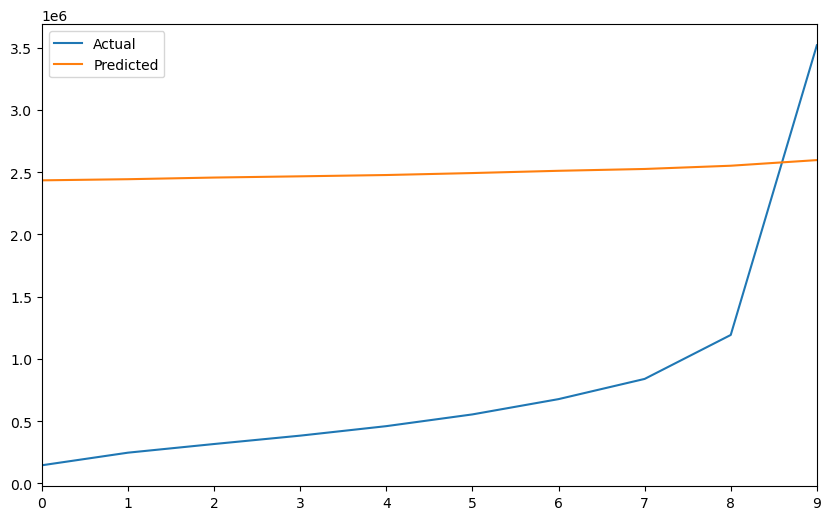

,bin,price,predicted_price,% diff
0,"(20999.999, 209000.0]",1.460939e+05,2.434505e+06,1566.397176
1,"(209000.0, 280000.0]",2.473352e+05,2.443545e+06,887.948948
2,"(280000.0, 349900.0]",3.168517e+05,2.456867e+06,675.399743
3,"(349900.0, 419900.0]",3.840645e+05,2.466726e+06,542.268691
4,"(419900.0, 499000.0]",4.603653e+05,2.477145e+06,438.082372
5,"(499000.0, 600000.0]",5.546495e+05,2.493036e+06,349.479564
6,"(600000.0, 749000.0]",6.773620e+05,2.511117e+06,270.720023
7,"(749000.0, 949900.0]",8.396428e+05,2.525771e+06,200.814999
8,"(949900.0, 1499900.0]",1.192671e+06,2.551780e+06,113.955050
9,"(1499900.0, 875000000.0]",3.519178e+06,2.597007e+06,-26.204166


In [17]:
train_pred = svr.predict(X_train_scaled)
y_train_df = y_train.to_frame() 
y_train_df['predicted_price'] = train_pred.tolist()
actual_vs_predicted(y_train_df,'price','predicted_price')

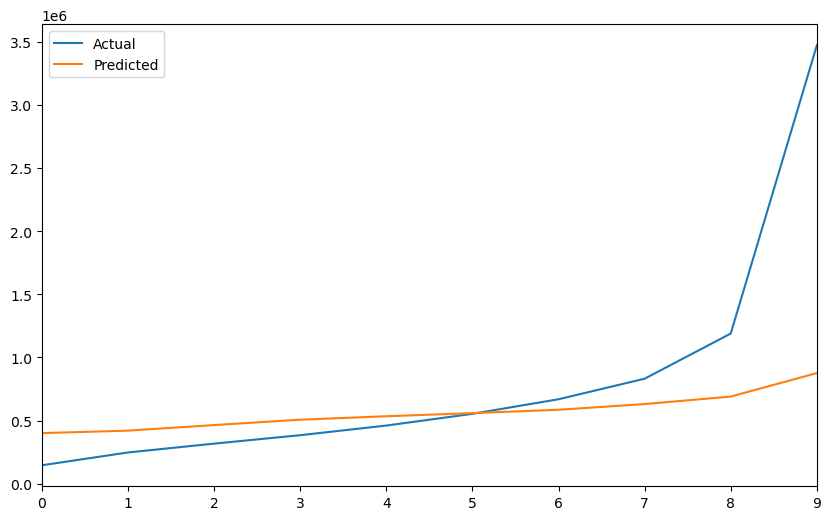

,bin,price,predicted_price,% diff
0,"(21899.999, 209000.0]",1.459123e+05,400635.282593,174.572671
1,"(209000.0, 280000.0]",2.473823e+05,420241.453090,69.875308
2,"(280000.0, 349900.0]",3.172891e+05,464344.471567,46.347436
3,"(349900.0, 419900.0]",3.841754e+05,506862.096714,31.935086
4,"(419900.0, 499000.0]",4.604341e+05,534146.172706,16.009254
5,"(499000.0, 599900.0]",5.532866e+05,558923.324264,1.018776
6,"(599900.0, 739000.0]",6.687597e+05,585578.261992,-12.438168
7,"(739000.0, 949000.0]",8.315160e+05,630584.674844,-24.164461
8,"(949000.0, 1499000.0]",1.189142e+06,689984.785829,-41.976228
9,"(1499000.0, 80000000.0]",3.471964e+06,876136.831705,-74.765386


In [18]:
valid_pred = svr.predict(X_valid_encoded)
y_valid_df = y_valid.to_frame() 
y_valid_df['predicted_price'] = valid_pred.tolist()
actual_vs_predicted(y_valid_df,'price','predicted_price')

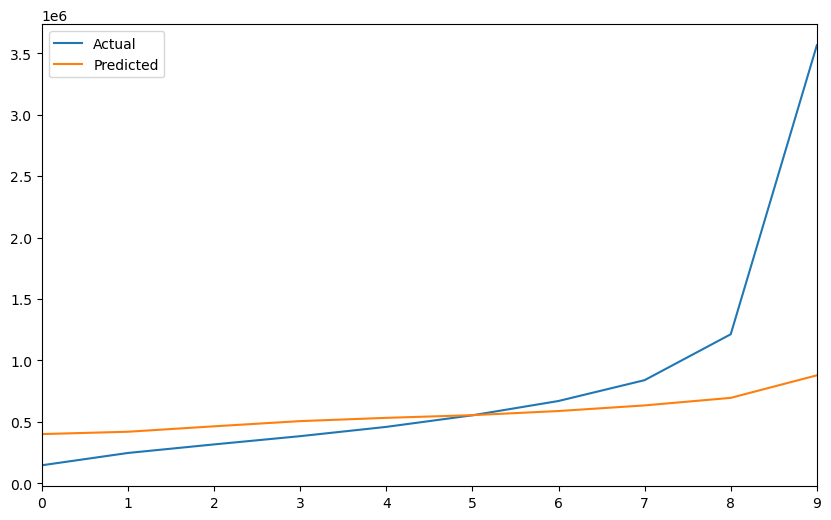

,bin,price,predicted_price,% diff
0,"(20799.999, 209500.0]",1.462774e+05,400091.584408,173.515689
1,"(209500.0, 279900.0]",2.465207e+05,419230.021567,70.058735
2,"(279900.0, 349900.0]",3.161726e+05,463381.734159,46.559744
3,"(349900.0, 419000.0]",3.832265e+05,505725.128038,31.965057
4,"(419000.0, 499000.0]",4.587775e+05,532236.231620,16.011848
5,"(499000.0, 599900.0]",5.530814e+05,554051.960383,0.175477
6,"(599900.0, 744900.0]",6.694738e+05,587817.833913,-12.197038
7,"(744900.0, 950000.0]",8.390530e+05,633543.214441,-24.493065
8,"(950000.0, 1500000.0]",1.212641e+06,694930.034536,-42.692845
9,"(1500000.0, 875000000.0]",3.564450e+06,878378.114519,-75.357258


In [19]:
test_pred = svr.predict(X_test_encoded)
y_test_df = y_test.to_frame() 
test_data['predicted_price'] = test_pred.tolist()
actual_vs_predicted(test_data,'price','predicted_price')

In [ ]:
# start_time = time.time()

# param_grid = { 
#     'n_estimators': [10, 25, 50, 100, 150, 200, 300], 
#     'max_features': ['sqrt', 'log2', None], 
#     'max_depth': [3, 5, 7, 9, 11, 15, 20], 
#     'max_leaf_nodes': [3, 6, 9,15], 
#     'min_samples_split': [2,5,10],
#     'min_samples_leaf': [0.01,0.03,0.05,0.07,0.1],
#     'max_samples' :[50,100,200,500,1000]
# } 

# from sklearn.model_selection import GridSearchCV

# rf = RandomForestRegressor(random_state=42)

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
# grid_search.fit(X_train_encoded, y_train)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"The code executed in {execution_time} seconds.")

In [119]:
import lightgbm as lgb


# Create the LightGBM regressor with default parameters
lgbm = lgb.LGBMRegressor()

# Fit the model
lgbm.fit(X_train, y_train)

# Evaluate the model
score_model(lgbm, X_train, y_train, X_valid, y_valid)

# Measure execution time if needed
end_time = time.time()
execution_time = end_time - start_time
print(f"The code executed in {execution_time} seconds.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 262889, number of used features: 13
[LightGBM] [Info] Start training from score 832282.111127
-----------------------------------------------------------------------------------
RESULTS
Train MSE:2050936573116.796, Valid MSE:627783636897.214
Train RMSE:1432109.134, Valid RMSE:792327.986
Train R2:0.746, Valid R2:0.734
Train MAE:307599.273, Valid MAE:310723.697
Train MAPE:0.569, Valid MAPE:0.576
The code executed in 4832.652389526367 seconds.


In [60]:
def convert_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return

In [91]:
import lightgbm as lgb

convert_to_category(X_train)
convert_to_category(X_valid)

train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

# this param creates the best model so far - 357039
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'rmse'},
#     'num_leaves': 128,
#     'learning_rate': 0.02,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 8,
#     'verbose': 3
# }

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'rmse'},
#     'num_leaves': 512,
#     'max_depth' : 15,
#     'num_iterations': 1000,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.9,
#     'bagging_freq': 5,
#     'verbose': 3
# }

# ******* test
# params = {
#         'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'rmse'},
#     'lambda_l1': 0.0004806424740085849, 
#  'lambda_l2': 0.5820991857362086, 
#  'num_leaves': 209, 
#  'feature_fraction': 0.5787961501403684, 
#  'bagging_fraction': 0.7634802492676318, 
#  'bagging_freq': 1, 
#  'min_child_samples': 7}

# RMSE = 350700.6731914919
# params = {'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'rmse'},
#     'lambda_l1': 0.2731462287867668,
#  'lambda_l2': 1.0759740749069788e-08,
#  'num_leaves': 142,
#  'feature_fraction': 0.5343720571837283,
#  'bagging_fraction': 0.9009393224558362,
#  'bagging_freq': 7,
#  'min_child_samples': 11}

# params = {'objective': 'regression',
#       'metric': 'rmse',
#       'verbosity': 1,
#       'boosting_type': 'gbdt',
#     'lambda_l1': 0.33788435732166894,
#   'lambda_l2': 2.195909564154052e-07, 
#   'num_leaves': 153, 
#   'feature_fraction': 0.5775106279133857, 
#   'bagging_fraction': 0.9868881190800155, 
#   'bagging_freq': 4, 
#   'min_child_samples': 5}

# Revised LightGBM model
params = {'objective': 'regression',
      'metric': 'rmse',
      'verbosity': 1,
      'boosting_type': 'gbdt',
      "n_estimators": 2000,
'lambda_l1': 0.1695819210191303, 
'lambda_l2': 0.013484816121600924, 
'num_leaves': 396,
 'feature_fraction': 0.8233438514350264, 
 'bagging_fraction': 0.6577707641779204, 
 'bagging_freq': 7, 
 'subsample': 0.20690378071711812,
   'colsample_bytree': 0.1722074965132815, 
   'learning_rate': 0.025498552935656327, 
   'min_data_in_leaf': 1}

# gbm = lgb.train(params,
#                 train_set=train_data,
#                 num_boost_round=2000,
#                 valid_sets=eval_data,
#                 callbacks=[lgb.early_stopping(stopping_rounds=100)])


gbm = lgb.train(params, train_data, valid_sets=[eval_data])

c:\Users\Martin\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8233438514350264, colsample_bytree=0.1722074965132815 will be ignored. Current value: feature_fraction=0.8233438514350264
[LightGBM] [Warning] bagging_fraction is set=0.6577707641779204, subsample=0.20690378071711812 will be ignored. Current value: bagging_fraction=0.6577707641779204
[LightGBM] [Warning] feature_fraction is set=0.8233438514350264, colsample_bytree=0.1722074965132815 will be ignored. Current value: feature_fraction=0.8233438514350264
[LightGBM] [Warning] bagging_fraction is set=0.6577707641779204, subsample=0.20690378071711812 will be ignored. Current value: bagging_fraction=0.6577707641779204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 262889, number of 

In [92]:
train_pred = gbm.predict(X_train)
valid_pred = gbm.predict(X_valid)

convert_to_category(X_test)
test_pred = gbm.predict(X_test)
y_test = test_data['price']

print(f"Train RMSE:{mean_squared_error(y_train,train_pred,squared=False):.3f}, Valid RMSE:{mean_squared_error(y_valid,valid_pred,squared=False):.3f}, Test RMSE:{mean_squared_error(y_test,test_pred,squared=False):.3f}")

Train RMSE:114888.414, Valid RMSE:353323.198, Test RMSE:324648.536


In [93]:
gbm.params

{'objective': 'regression',
 'metric': 'rmse',
 'verbosity': 1,
 'boosting_type': 'gbdt',
 'lambda_l1': 0.1695819210191303,
 'lambda_l2': 0.013484816121600924,
 'num_leaves': 396,
 'feature_fraction': 0.8233438514350264,
 'bagging_fraction': 0.6577707641779204,
 'bagging_freq': 7,
 'subsample': 0.20690378071711812,
 'colsample_bytree': 0.1722074965132815,
 'learning_rate': 0.025498552935656327,
 'min_data_in_leaf': 1,
 'num_iterations': 2000,
 'categorical_column': [0, 1]}

lightgbm model, after hyperparamter tunning, achieved a training RMSE of 114888, valid RMSE of 353323, test RMSE 324648. Although it's overfitting to the training data, but the model's performance is better than the RF model on the test data. So we will use this lightgbm model.

{'objective': 'regression',
 'metric': 'rmse',
 'verbosity': 1,
 'boosting_type': 'gbdt',
 'lambda_l1': 0.1695819210191303,
 'lambda_l2': 0.013484816121600924,
 'num_leaves': 396,
 'feature_fraction': 0.8233438514350264,
 'bagging_fraction': 0.6577707641779204,
 'bagging_freq': 7,
 'subsample': 0.20690378071711812,
 'colsample_bytree': 0.1722074965132815,
 'learning_rate': 0.025498552935656327,
 'min_data_in_leaf': 1,
 'num_iterations': 2000,
 'categorical_column': [0, 1]}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

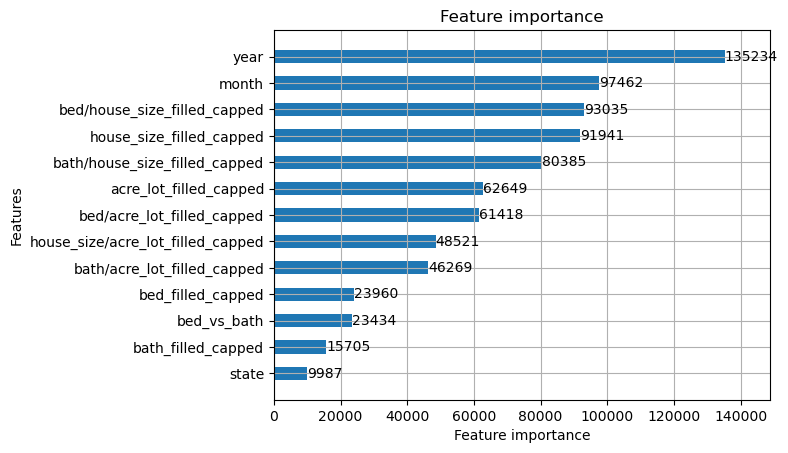

In [94]:
lgb.plot_importance(gbm,height=0.5)

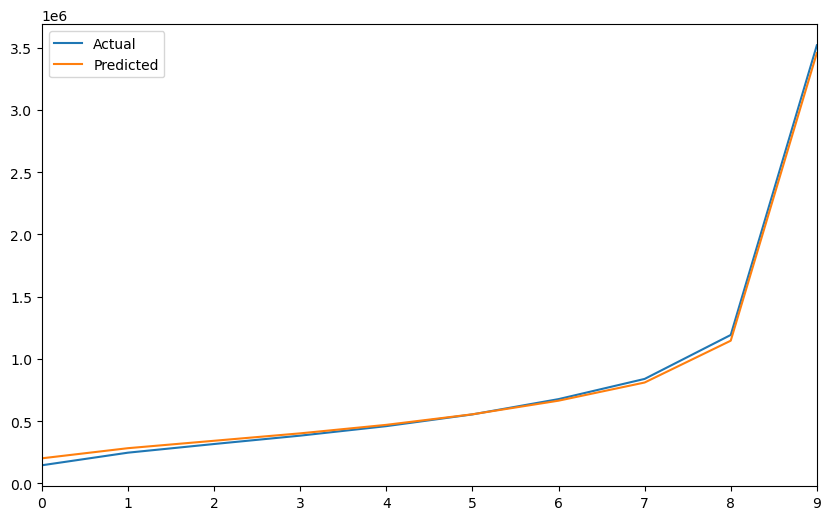

,bin,price,predicted_price,% diff
0,"(20999.999, 209000.0]",1.460939e+05,2.019853e+05,38.257118
1,"(209000.0, 280000.0]",2.473352e+05,2.833776e+05,14.572296
2,"(280000.0, 349900.0]",3.168517e+05,3.428802e+05,8.214704
3,"(349900.0, 419900.0]",3.840645e+05,4.025275e+05,4.807251
4,"(419900.0, 499000.0]",4.603653e+05,4.708039e+05,2.267461
5,"(499000.0, 600000.0]",5.546495e+05,5.555340e+05,0.159466
6,"(600000.0, 749000.0]",6.773620e+05,6.647945e+05,-1.855363
7,"(749000.0, 949900.0]",8.396428e+05,8.107328e+05,-3.443131
8,"(949900.0, 1499900.0]",1.192671e+06,1.146647e+06,-3.858954
9,"(1499900.0, 875000000.0]",3.519178e+06,3.457068e+06,-1.764898


In [95]:
# lightgbm model performance oh training dataset
train_pred = gbm.predict(X_train)
y_train_df = y_train.to_frame() 
y_train_df['predicted_price'] = train_pred.tolist()
actual_vs_predicted(y_train_df,'price','predicted_price')

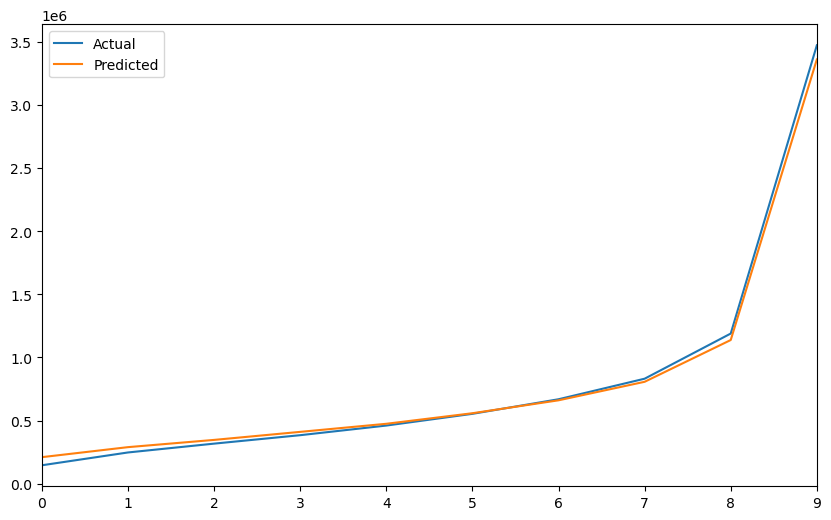

,bin,price,predicted_price,% diff
0,"(21899.999, 209000.0]",1.459123e+05,2.101779e+05,44.043982
1,"(209000.0, 280000.0]",2.473823e+05,2.894826e+05,17.018317
2,"(280000.0, 349900.0]",3.172891e+05,3.468370e+05,9.312618
3,"(349900.0, 419900.0]",3.841754e+05,4.104689e+05,6.844137
4,"(419900.0, 499000.0]",4.604341e+05,4.744661e+05,3.047552
5,"(499000.0, 599900.0]",5.532866e+05,5.580507e+05,0.861051
6,"(599900.0, 739000.0]",6.687597e+05,6.603861e+05,-1.252109
7,"(739000.0, 949000.0]",8.315160e+05,8.070221e+05,-2.945697
8,"(949000.0, 1499000.0]",1.189142e+06,1.137859e+06,-4.312585
9,"(1499000.0, 80000000.0]",3.471964e+06,3.359834e+06,-3.229606


In [96]:
# lightgbm model performance oh validation dataset
valid_pred = gbm.predict(X_valid)
y_valid_df = y_valid.to_frame() 
y_valid_df['predicted_price'] = valid_pred.tolist()
actual_vs_predicted(y_valid_df,'price','predicted_price')

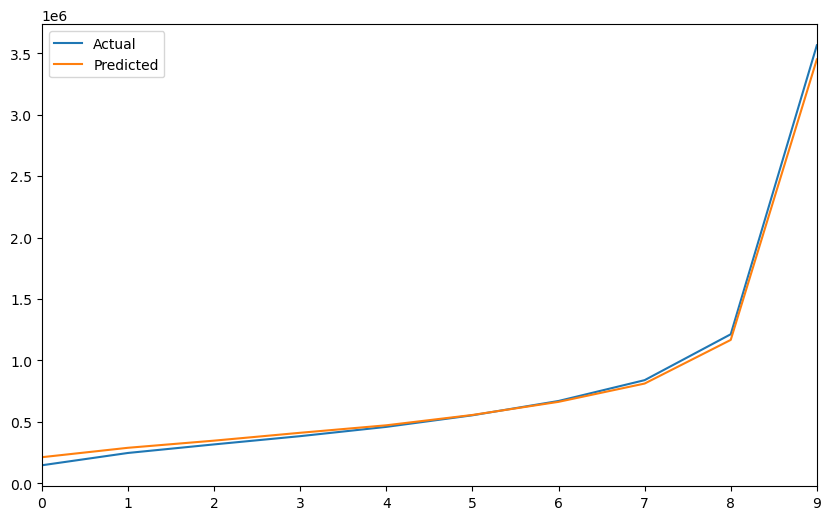

,bin,price,predicted_price,% diff
0,"(20799.999, 209500.0]",1.462774e+05,2.119598e+05,44.902620
1,"(209500.0, 279900.0]",2.465207e+05,2.886066e+05,17.071943
2,"(279900.0, 349900.0]",3.161726e+05,3.467329e+05,9.665710
3,"(349900.0, 419000.0]",3.832265e+05,4.107231e+05,7.175004
4,"(419000.0, 499000.0]",4.587775e+05,4.716503e+05,2.805905
5,"(499000.0, 599900.0]",5.530814e+05,5.557674e+05,0.485631
6,"(599900.0, 744900.0]",6.694738e+05,6.625117e+05,-1.039934
7,"(744900.0, 950000.0]",8.390530e+05,8.113934e+05,-3.296530
8,"(950000.0, 1500000.0]",1.212641e+06,1.166611e+06,-3.795806
9,"(1500000.0, 875000000.0]",3.564450e+06,3.449748e+06,-3.217919


In [97]:
# lightgbm model performance oh test dataset
convert_to_category(X_test)
test_pred = gbm.predict(X_test)
test_data['predicted_price'] = test_pred.tolist()
actual_vs_predicted(test_data,'price','predicted_price')

In [101]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

# convert_to_category(X_train)
# convert_to_category(X_valid)

# def objective(trial):
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         "num_iterations": 500,
#         'verbosity': 1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 0.5),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 0.5),
#         'num_leaves': trial.suggest_int('num_leaves', 32, 512),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#         # 'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
#         'verbose_eval': False
#     }

#     train_data = lgb.Dataset(X_train, y_train)
#     eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data, free_raw_data=False)

#     gbm = lgb.train(param, train_data, valid_sets=[eval_data])
#     train_preds = gbm.predict(X_train)
#     preds = gbm.predict(X_valid)

#     train_rmse = mean_squared_error(y_train, train_preds, squared=False)
#     rmse = mean_squared_error(y_valid, preds, squared=False)

#     print(f'Train RMSE: {train_rmse}, Valid RMSE: {rmse}')

#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print('Best trial:', study.best_trial.params)

In [102]:
# print('Best hyperparameters:', study.best_params)
# print('Best RMSE:', study.best_value)


In [87]:
# best_params = study.best_trial.params
# best params using num_boost_round=50000, (stopping_rounds=2000)
# best_params = {'lambda_l1': 0.2731462287867668,
#  'lambda_l2': 1.0759740749069788e-08,
#  'num_leaves': 142,
#  'feature_fraction': 0.5343720571837283,
#  'bagging_fraction': 0.9009393224558362,
#  'bagging_freq': 7,
#  'min_child_samples': 11}

# final selected params - Nov 27th
# best_params = {'objective': 'regression',
#       'metric': 'rmse',
#       'verbosity': 1,
#       'boosting_type': 'gbdt',
#     'lambda_l1': 0.33788435732166894,
#   'lambda_l2': 2.195909564154052e-07, 
#   'num_leaves': 153, 
#   'feature_fraction': 0.5775106279133857, 
#   'bagging_fraction': 0.9868881190800155, 
#   'bagging_freq': 4, 
#   'min_child_samples': 5}

# best_params ={'objective': 'regression',
#       'metric': 'rmse',
#       'verbosity': 1,
#       'boosting_type': 'gbdt',
# 'lambda_l1': 0.13691635551977477,
#  'lambda_l2': 0.8407337701431611,
#  'num_leaves': 124,
#  'feature_fraction': 0.5746663766558099,
#  'bagging_fraction': 0.8335240889518275,
#  'bagging_freq': 7,
#  'min_child_samples': 95}

# Nov 28th. Revised ver 1
# result 152510.8843693191
# 382613.27886192035
# 336819.05458449695
# best_params = {'objective': 'regression',
#       'metric': 'rmse',
#       'verbosity': 1,
#       'boosting_type': 'gbdt',
#       "n_estimators": 1000,
#     'lambda_l1': 0.07335143195239793, 
#     'lambda_l2': 0.0001669743629081159, 
#     'num_leaves': 122, 
#     'feature_fraction': 0.9580198802971479, 
#     'bagging_fraction': 0.9375391787792848, 
#     'bagging_freq': 4, 
#     'subsample': 0.7930186780113694,
#       'colsample_bytree': 0.3890309403344545,
#         'learning_rate': 0.09769074120619646, 
#         'min_data_in_leaf': 1}

# Nov 28th. Revised ver 2
best_params = {'objective': 'regression',
      'metric': 'rmse',
      'verbosity': 1,
      'boosting_type': 'gbdt',
      "n_estimators": 500,
      'lambda_l1': 0.0006550324245593119, 
      'lambda_l2': 0.13369379250963898,
      'num_leaves': 453,
      'feature_fraction': 0.6146859320907332,
     'bagging_fraction': 0.4988236819421642,
       'bagging_freq': 8,
         'subsample': 0.3321754061799471, 
         'colsample_bytree': 0.537779667778094, 
         'learning_rate': 0.051623609729566936,
           'min_data_in_leaf': 1}

In [88]:
# best_params = study.best_trial.params
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data, free_raw_data=False)

gbm = lgb.train(best_params, train_data, valid_sets=[eval_data])
train_preds = gbm.predict(X_train)
valid_preds = gbm.predict(X_valid)

convert_to_category(X_test)
test_preds = gbm.predict(X_test)
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
valid_rmse = mean_squared_error(y_valid, valid_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
print(train_rmse)
print(valid_rmse)
print(test_rmse)

c:\Users\Martin\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6146859320907332, colsample_bytree=0.537779667778094 will be ignored. Current value: feature_fraction=0.6146859320907332
[LightGBM] [Warning] bagging_fraction is set=0.4988236819421642, subsample=0.3321754061799471 will be ignored. Current value: bagging_fraction=0.4988236819421642
[LightGBM] [Warning] feature_fraction is set=0.6146859320907332, colsample_bytree=0.537779667778094 will be ignored. Current value: feature_fraction=0.6146859320907332
[LightGBM] [Warning] bagging_fraction is set=0.4988236819421642, subsample=0.3321754061799471 will be ignored. Current value: bagging_fraction=0.4988236819421642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 262889, number of used

### Model without Year/month. Can be used to predict listing records

In [104]:
# create another lightgbm modle without year/month. So can be used to predict on the non-sold records
train_data, test_data = train_test_split(dataset, test_size=0.4, random_state=999)
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=999)

y_train = train_data['price']
# y_train = np.log(train_data['price'])
X_train = train_data.drop(['price','year','month'],axis=1)

y_valid = validation_data['price']
# y_valid = np.log(validation_data['price'])
X_valid = validation_data.drop(['price','year','month'],axis=1)

y_test = test_data['price']
# y_test = np.log(test_data['price'])
X_test = test_data.drop(['price','year','month'],axis=1)

convert_to_category(X_train)
convert_to_category(X_valid)

In [167]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# def objective(trial):
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': 1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 128),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'verbose_eval': False
#     }

#     train_data = lgb.Dataset(X_train, y_train)
#     eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data, free_raw_data=False)

#     gbm = lgb.train(param, train_data, num_boost_round=10000, valid_sets=[eval_data], callbacks=[lgb.early_stopping(stopping_rounds=500)])
#     preds = gbm.predict(X_valid)
#     rmse = mean_squared_error(y_valid, preds, squared=False)
#     print(f'Trial {trial.number}: RMSE = {rmse:.4f}')
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best trial:', study.best_trial.params)

In [122]:
# def objective(trial):
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': 1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-6, 1.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-6, 1.0),
#         'num_leaves': trial.suggest_int('num_leaves', 32, 512),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 3, 7),
#         # 'min_child_samples': trial.suggest_int('min_child_samples', 3, 100),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-5, 0.1, log=True),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 100)
#     }

#     train_data = lgb.Dataset(X_train, y_train)
#     eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data, free_raw_data=False)

#     gbm = lgb.train(param, train_data, num_boost_round=500, valid_sets=[eval_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])
#     preds = gbm.predict(X_valid)
#     rmse = mean_squared_error(y_valid, preds, squared=False)
#     print(f'Trial {trial.number}: RMSE = {rmse:.4f}')
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print('Best trial:', study.best_trial.params)

In [123]:
# print('Best hyperparameters:', study.best_params)
# print('Best RMSE:', study.best_value)

In [120]:
# best_params = study.best_trial.params
best_params = {'objective': 'regression',
        'metric': 'rmse',
        'verbosity': 1,
        'boosting_type': 'gbdt',
        'lambda_l1': 5.670476821992888, 
        'lambda_l2': 6.085309024377948e-05, 
        'num_leaves': 256, 
        'feature_fraction': 0.7544551939066134,
          'bagging_fraction': 0.7968620252988394, 
          'bagging_freq': 3, 
          'subsample': 0.3527712784999291, 
          'colsample_bytree': 0.07359778886216994, 
          'learning_rate': 0.09698576125541912,
            'min_data_in_leaf': 4}



# model performance on validation set
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_valid, y_valid, reference=train_data, free_raw_data=False)
# gbm = lgb.train(best_params, train_data, num_boost_round=10000, valid_sets=[eval_data], callbacks=[lgb.early_stopping(stopping_rounds=500)])
gbm = lgb.train(best_params, train_data, num_boost_round=1000, valid_sets=[eval_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Warning] feature_fraction is set=0.7544551939066134, colsample_bytree=0.07359778886216994 will be ignored. Current value: feature_fraction=0.7544551939066134
[LightGBM] [Warning] bagging_fraction is set=0.7968620252988394, subsample=0.3527712784999291 will be ignored. Current value: bagging_fraction=0.7968620252988394
[LightGBM] [Warning] feature_fraction is set=0.7544551939066134, colsample_bytree=0.07359778886216994 will be ignored. Current value: feature_fraction=0.7544551939066134
[LightGBM] [Warning] bagging_fraction is set=0.7968620252988394, subsample=0.3527712784999291 will be ignored. Current value: bagging_fraction=0.7968620252988394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 262889, number of used features: 11
[LightGBM] [Warning] feature_fraction is set=0

In [121]:
train_pred = gbm.predict(X_train)
valid_pred = gbm.predict(X_valid)

convert_to_category(X_test)
test_pred = gbm.predict(X_test)
y_test = test_data['price']

print(f"Train RMSE:{mean_squared_error(y_train,train_pred,squared=False):.3f}, Valid RMSE:{mean_squared_error(y_valid,valid_pred,squared=False):.3f}, Test RMSE:{mean_squared_error(y_test,test_pred,squared=False):.3f}")

Train RMSE:512039.171, Valid RMSE:587795.262, Test RMSE:548878.177


In [124]:
# check RSME on test data by state
def calculate_rmse(group):
    return np.sqrt(mean_squared_error(group['price'], group['predicted']))

X_test_state = test_data.copy()
X_test_state['predicted'] = test_pred.tolist()
rmse_by_state = X_test_state.groupby('state').apply(calculate_rmse).sort_values()

print(rmse_by_state)

state
Vermont           81989.182867
New Hampshire     92259.643888
Rhode Island     136680.735652
Maine            150796.666475
Massachusetts    265077.726252
New Jersey       342914.971510
Pennsylvania     697109.069340
Connecticut      720896.364252
New York         830530.861038
dtype: float64


In [125]:
# check average of year(sold_date) on testing dataset
test_data.groupby('state')['year'].mean().sort_values()

state
Massachusetts    2004.153066
New Jersey       2009.179047
Connecticut      2009.324253
Pennsylvania     2009.785814
New York         2010.496669
Rhode Island     2012.553608
Vermont          2012.800387
New Hampshire    2013.251640
Maine            2013.727361
Name: year, dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

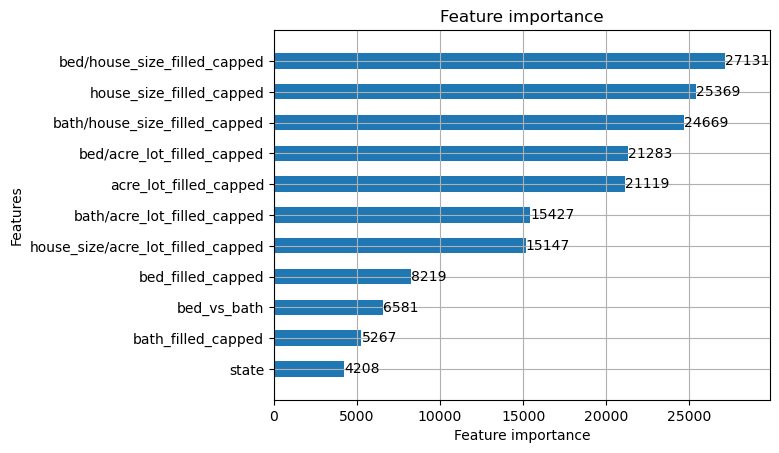

In [126]:
lgb.plot_importance(gbm,height=0.5)

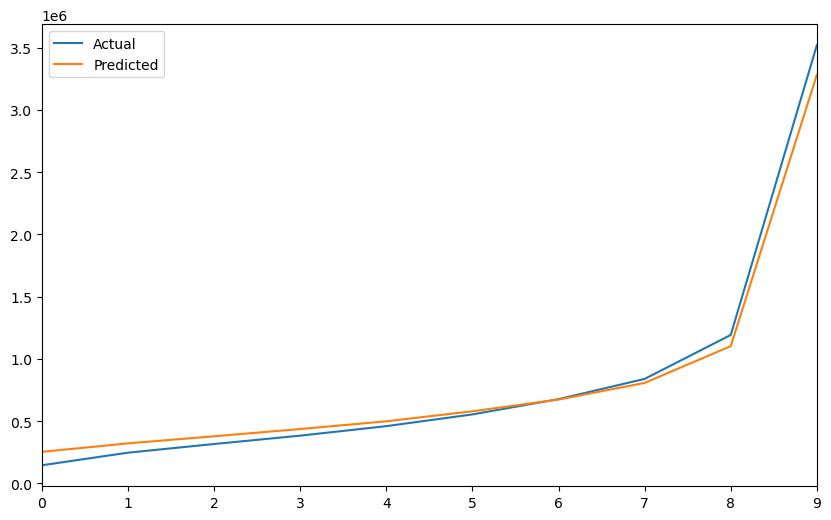

,bin,price,predicted_price,% diff
0,"(20999.999, 209000.0]",1.460939e+05,2.538434e+05,73.753522
1,"(209000.0, 280000.0]",2.473352e+05,3.221736e+05,30.257923
2,"(280000.0, 349900.0]",3.168517e+05,3.790617e+05,19.633767
3,"(349900.0, 419900.0]",3.840645e+05,4.371439e+05,13.820441
4,"(419900.0, 499000.0]",4.603653e+05,4.991920e+05,8.433888
5,"(499000.0, 600000.0]",5.546495e+05,5.796385e+05,4.505362
6,"(600000.0, 749000.0]",6.773620e+05,6.739745e+05,-0.500112
7,"(749000.0, 949900.0]",8.396428e+05,8.075618e+05,-3.820788
8,"(949900.0, 1499900.0]",1.192671e+06,1.102976e+06,-7.520549
9,"(1499900.0, 875000000.0]",3.519178e+06,3.281978e+06,-6.740206


In [127]:
# lightgbm model performance on training dataset
train_pred = gbm.predict(X_train)
y_train_df = y_train.to_frame() 
y_train_df['predicted_price'] = train_pred.tolist()
actual_vs_predicted(y_train_df,'price','predicted_price')

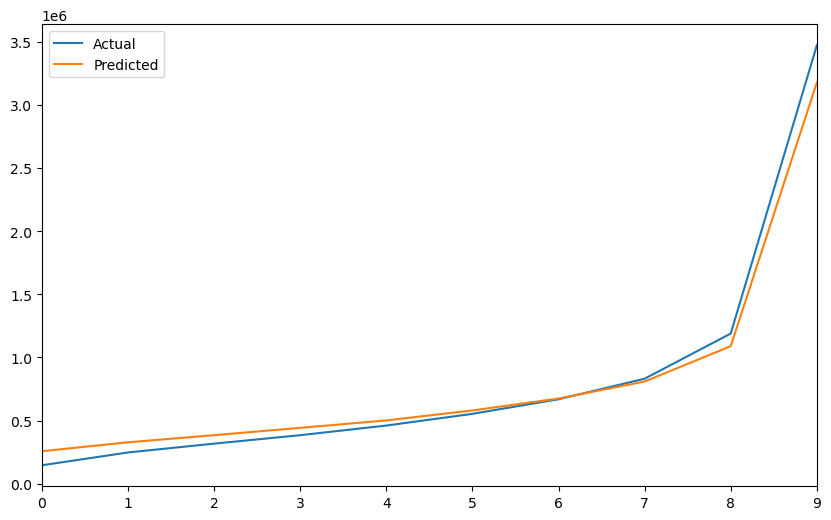

,bin,price,predicted_price,% diff
0,"(21899.999, 209000.0]",1.459123e+05,2.572669e+05,76.316124
1,"(209000.0, 280000.0]",2.473823e+05,3.278555e+05,32.529904
2,"(280000.0, 349900.0]",3.172891e+05,3.842100e+05,21.091472
3,"(349900.0, 419900.0]",3.841754e+05,4.423167e+05,15.134049
4,"(419900.0, 499000.0]",4.604341e+05,5.011063e+05,8.833448
5,"(499000.0, 599900.0]",5.532866e+05,5.800385e+05,4.835102
6,"(599900.0, 739000.0]",6.687597e+05,6.747459e+05,0.895112
7,"(739000.0, 949000.0]",8.315160e+05,8.091364e+05,-2.691427
8,"(949000.0, 1499000.0]",1.189142e+06,1.089163e+06,-8.407584
9,"(1499000.0, 80000000.0]",3.471964e+06,3.176580e+06,-8.507718


In [128]:
# lightgbm model performance on validation dataset
valid_pred = gbm.predict(X_valid)
y_valid_df = y_valid.to_frame() 
y_valid_df['predicted_price'] = valid_pred.tolist()
actual_vs_predicted(y_valid_df,'price','predicted_price')

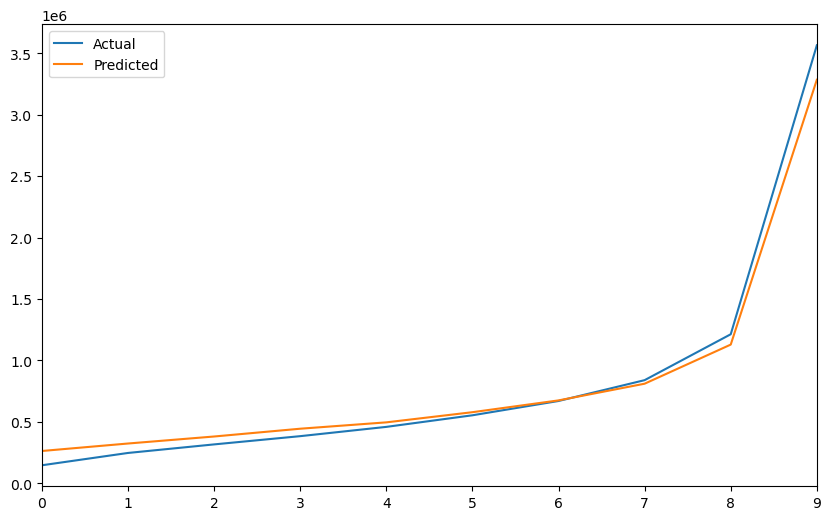

,bin,price,predicted_price,% diff
0,"(20799.999, 209500.0]",1.462774e+05,2.625264e+05,79.471665
1,"(209500.0, 279900.0]",2.465207e+05,3.233914e+05,31.182256
2,"(279900.0, 349900.0]",3.161726e+05,3.804309e+05,20.323811
3,"(349900.0, 419000.0]",3.832265e+05,4.438092e+05,15.808586
4,"(419000.0, 499000.0]",4.587775e+05,4.955575e+05,8.016969
5,"(499000.0, 599900.0]",5.530814e+05,5.782435e+05,4.549426
6,"(599900.0, 744900.0]",6.694738e+05,6.742658e+05,0.715792
7,"(744900.0, 950000.0]",8.390530e+05,8.101875e+05,-3.440250
8,"(950000.0, 1500000.0]",1.212641e+06,1.128525e+06,-6.936584
9,"(1500000.0, 875000000.0]",3.564450e+06,3.283928e+06,-7.869981


In [129]:
# lightgbm model performance on test dataset
test_pred = gbm.predict(X_test)
test_data['predicted_price'] = test_pred.tolist()
actual_vs_predicted(test_data,'price','predicted_price')

The model without year/month is over-predicting for the lower price buckets. It may be explained by those lower price records are indeed from earlier years. (can test this)

In [133]:
# load the listing price only data. then use the fitted model to predict on the sale price.
listing_price = pd.read_parquet('../Data/listing_price_only_data.parquet')

variables = ['price',
            'state',
            'bed_vs_bath',
            'house_size_filled_capped',
            'bed_filled_capped',
            'bath_filled_capped',
            'acre_lot_filled_capped',
            'bed/house_size_filled_capped',
            'bath/house_size_filled_capped',
            'bed/acre_lot_filled_capped',
            'bath/acre_lot_filled_capped',
            'house_size/acre_lot_filled_capped']
listing_price = listing_price.loc[:,variables]
listing_price.reset_index(drop=True,inplace=True)

y_listing = listing_price['price']
# y_test = np.log(test_data['price'])
X_listing = listing_price.drop('price',axis=1)

convert_to_category(X_listing)
test_pred = gbm.predict(X_listing)
mean_squared_error(y_listing,test_pred,squared=False)

2792627.748946231

In [134]:
listing_price['predicted_price'] = test_pred.tolist()
listing_price['percentage_difference'] = (listing_price['predicted_price'] / listing_price['price']) - 1

bins = [-np.inf, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, np.inf]
group_names = ['(<-100%)','(-100%,-50%)', '(-50%, -20%)', '(-20%, -10%)', '(-10%, 0%)', '(0%,10%)', '(10%,20%)', '(20%,50%)', '(50%,100%)', '(100%,200%)', '(200%+)']
listing_price['grouped_percentage_difference'] = pd.cut(listing_price['percentage_difference'], bins, labels=group_names)

# Check the counts of grouped buckets by states
counts = listing_price.groupby(['state', 'grouped_percentage_difference']).size()
comparison_by_state = counts.reset_index(name='count')

In [136]:
counts = listing_price.groupby(['state', 'grouped_percentage_difference']).size()
total_counts = listing_price.groupby('state').size()
percentage_counts = counts / total_counts
percentage_counts_df = percentage_counts.reset_index(name='percentage')
percentage_counts_df['percentage'] *= 100
percentage_counts_df.to_excel('../Visualizations/summary.xlsx',index=False)

Look at the analysis tab of the excel in the Visualizations folder. We can draw conclusion that our model seems to be a good fit for Connecticut, New Jersey, Rhode Island. (We can further test the original model performance-RMSE by state)

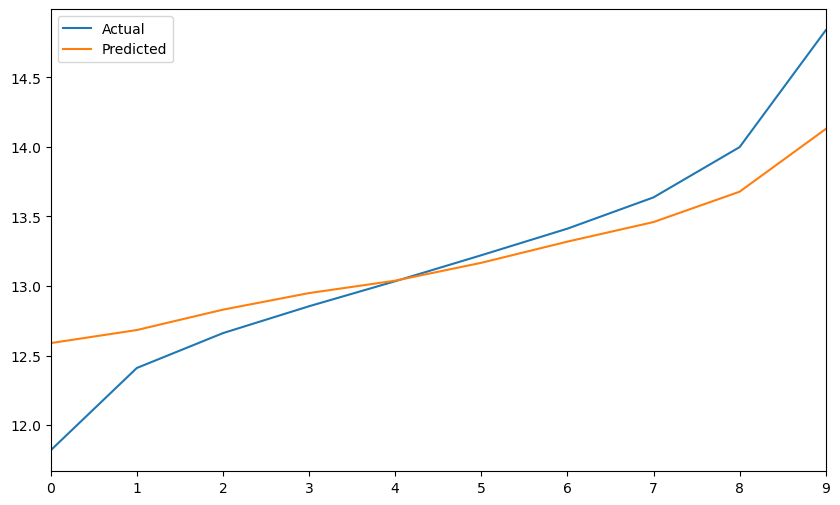

,bin,actual_col,pred_col,% diff
0,"(9.942, 12.252]",11.820190,12.590304,6.515248
1,"(12.252, 12.542]",12.411578,12.684252,2.196932
2,"(12.542, 12.765]",12.661933,12.830596,1.332051
3,"(12.765, 12.946]",12.855143,12.949779,0.736168
4,"(12.946, 13.12]",13.034845,13.038915,0.031227
5,"(13.12, 13.305]",13.221583,13.167272,-0.410771
6,"(13.305, 13.521]",13.412605,13.319431,-0.694680
7,"(13.521, 13.764]",13.637333,13.460011,-1.300269
8,"(13.764, 14.221]",13.998562,13.678168,-2.288762
9,"(14.221, 20.59]",14.838075,14.128802,-4.780088


In [3]:
# multi linear model performance on dataset
linear_model_result = pd.read_csv('../Data/multilinear regression prediction_result.csv')
actual_vs_predicted(linear_model_result,'actual_col','pred_col')

In [4]:
listing_price = pd.read_parquet('../Data/listing_price_only_data.parquet')
listing_price['state'].value_counts()

state
Massachusetts    102196
New York          86333
New Jersey        80400
New Hampshire     37378
Vermont           35553
Connecticut       34541
Maine             30988
Rhode Island      14836
Pennsylvania       5024
Virginia             31
Tennessee            20
Wyoming               3
West Virginia         3
Name: count, dtype: int64